# Multimodal Property Valuation - Model Training Pipeline
## Satellite Imagery-Based Property Valuation

This notebook covers:
1. **CNN Feature Extraction** - Extract deep features from satellite images
2. **Baseline Models (Tabular-Only)** - ML models on tabular data
3. **Baseline Models (Image-Only)** - ML models on CNN features
4. **Multimodal ML Models** - Combine tabular + CNN features
5. **Deep Learning Models** - End-to-end multimodal neural networks
6. **Model Evaluation** - Comprehensive comparison and analysis
7. **Grad-CAM Explainability** - Visualize what the model sees

**Evaluation Strategy**: Track both train and validation metrics to detect overfitting

In [1]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.7 MB/s eta 0:00:00


In [2]:
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 66.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.5-py3-none-any.whl size=44284 sha256=41e4d23d013ba75cd90ca69067a19929600755d2aac944792243186d548b126f
  Stored in directory: /root/.cache/pip/wheels/fb/3b/09/2afc520f3d69bc26ae6bd87416759c820a3f7d05c1a077bbf6
Successfully built grad-cam


In [3]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import warnings
warnings.filterwarnings('ignore')

# Machine Learning
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

# Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

# Deep Learning
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
from torchvision import transforms
from tqdm import tqdm
import joblib
from PIL import Image

# Visualization
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
# Removed: from pytorch_grad_cam.utils.model_targets import RegressionModelTarget

# Settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

pd.set_option('display.max_columns', None)
np.random.seed(42)
torch.manual_seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print("✅ Libraries imported successfully!")

Using device: cuda
✅ Libraries imported successfully!


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


---
## 1. Load Processed Data

Load the data from feature engineering pipeline.

In [5]:

# Paths - UPDATE THESE
TRAIN_CSV = '/content/drive/MyDrive/CDC project/processed_data/train_processed.csv'
VAL_CSV = '/content/drive/MyDrive/CDC project/processed_data/val_processed.csv'
TRAIN_IMAGE_DIR = '/content/drive/MyDrive/CDC project/satellite_images_19 copy'
FEATURE_LIST_PATH = '/content/drive/MyDrive/CDC project/processed_data/selected_features.txt'
SCALER_PATH = '/content/drive/MyDrive/CDC project/processed_data/feature_scaler.pkl'
IMAGE_MEAN_PATH = '/content/drive/MyDrive/CDC project/processed_data/image_mean.npy'
IMAGE_STD_PATH = '/content/drive/MyDrive/CDC project/processed_data/image_std.npy'


# Load data
train_df = pd.read_csv(TRAIN_CSV)
val_df = pd.read_csv(VAL_CSV)

print(f"Training data: {train_df.shape}")
print(f"Validation data: {val_df.shape}")

# Load selected features
with open(FEATURE_LIST_PATH, 'r') as f:
    SELECTED_FEATURES = [line.strip() for line in f]

print(f"\nNumber of selected features: {len(SELECTED_FEATURES)}")
print(f"\nSelected features: {SELECTED_FEATURES[:10]}...")

# Load scaler
scaler = joblib.load(SCALER_PATH)

# Load image normalization params
IMAGE_MEAN = np.load(IMAGE_MEAN_PATH)
IMAGE_STD = np.load(IMAGE_STD_PATH)

print(f"\nImage mean: {IMAGE_MEAN}")
print(f"Image std: {IMAGE_STD}")

# Prepare X and y
X_train = train_df[SELECTED_FEATURES].values
y_train = train_df['price'].values

X_val = val_df[SELECTED_FEATURES].values
y_val = val_df['price'].values

print(f"\nX_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")

Training data: (12967, 82)
Validation data: (3242, 82)

Number of selected features: 32

Selected features: ['bathroom_to_bedroom_ratio', 'bathrooms', 'blueness', 'brightness', 'dist_from_center', 'edge_density', 'grade', 'greenness', 'has_view', 'lat']...

Image mean: [0.40738422 0.43434748 0.42324078]
Image std: [0.0756806  0.06009437 0.04780986]

X_train shape: (12967, 32)
y_train shape: (12967,)
X_val shape: (3242, 32)
y_val shape: (3242,)


---
## 2. CNN FEATURE EXTRACTION

Extract deep features from satellite images using pre-trained ResNet50.

### 2.1 Define Feature Extractor

In [ ]:
class CNNFeatureExtractor(nn.Module):
    """
    Extract features using pre-trained ResNet50
    Remove final classification layer to get 2048-dim features
    """
    def __init__(self):
        super(CNNFeatureExtractor, self).__init__()
        # Load pre-trained ResNet50
        resnet = models.resnet50(pretrained=True)
        # Remove the final fully connected layer
        self.features = nn.Sequential(*list(resnet.children())[:-1])

        # Freeze the weights (we're just extracting features)
        for param in self.features.parameters():
            param.requires_grad = False

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)  # Flatten to (batch_size, 2048)
        return x

# Initialize feature extractor
feature_extractor = CNNFeatureExtractor().to(device)
feature_extractor.eval()

print("✅ CNN Feature Extractor initialized!")
print(f"Output feature dimension: 2048")

### 2.2 Image Dataset for Feature Extraction

In [ ]:
class ImageDatasetForFeatures(Dataset):
    """
    Simple dataset to load images for feature extraction
    """
    def __init__(self, df, image_dir, image_col='image_name', transform=None):
        self.df = df.reset_index(drop=True)
        self.image_dir = image_dir
        self.image_col = image_col
        self.transform = transform

        # Find valid indices
        self.valid_indices = []
        self.id_to_idx = {}

        for idx in range(len(self.df)):
            img_path = os.path.join(self.image_dir, self.df.loc[idx, self.image_col])
            if os.path.exists(img_path):
                self.valid_indices.append(idx)
                self.id_to_idx[self.df.loc[idx, 'id']] = idx

    def __len__(self):
        return len(self.valid_indices)

    def __getitem__(self, idx):
        actual_idx = self.valid_indices[idx]

        img_name = self.df.loc[actual_idx, self.image_col]
        img_path = os.path.join(self.image_dir, img_name)

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (224, 224))

        if self.transform:
            image = self.transform(image)

        return {
            'image': image,
            'id': self.df.loc[actual_idx, 'id']
        }

# Define transforms
feature_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGE_MEAN, std=IMAGE_STD)
])

print("✅ Image dataset class defined!")

### 2.3 Extract CNN Features

In [ ]:
def extract_cnn_features(df, image_dir, feature_extractor, batch_size=32):
    """
    Extract CNN features for all images in dataframe

    Returns:
        features_dict: {property_id: feature_vector}
    """
    dataset = ImageDatasetForFeatures(df, image_dir, transform=feature_transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    features_dict = {}

    print(f"Extracting features for {len(dataset)} images...")

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Extracting CNN features"):
            images = batch['image'].to(device)
            ids = batch['id']

            # Extract features
            features = feature_extractor(images)
            features = features.cpu().numpy()

            # Store features by ID
            for i, prop_id in enumerate(ids):
                features_dict[prop_id.item()] = features[i]

    return features_dict

# Extract features for train and validation
print("\n" + "="*60)
print("EXTRACTING CNN FEATURES")
print("="*60)

train_cnn_features = extract_cnn_features(train_df, TRAIN_IMAGE_DIR, feature_extractor)
val_cnn_features = extract_cnn_features(val_df, TRAIN_IMAGE_DIR, feature_extractor)

print(f"\n✅ CNN features extracted!")
print(f"Train features: {len(train_cnn_features)} properties")
print(f"Val features: {len(val_cnn_features)} properties")
print(f"Feature dimension: {list(train_cnn_features.values())[0].shape}")

### 2.4 Create Feature Matrices

In [ ]:
import os

os.makedirs("./processed_data", exist_ok=True)


In [ ]:
def create_feature_matrix(df, cnn_features_dict):
    """
    Create matrix of CNN features aligned with dataframe
    Fill missing with zeros
    """
    feature_dim = 2048
    feature_matrix = np.zeros((len(df), feature_dim))

    for idx, prop_id in enumerate(df['id']):
        if prop_id in cnn_features_dict:
            feature_matrix[idx] = cnn_features_dict[prop_id]

    return feature_matrix

# Create CNN feature matrices
X_train_cnn = create_feature_matrix(train_df, train_cnn_features)
X_val_cnn = create_feature_matrix(val_df, val_cnn_features)

print(f"Train CNN features shape: {X_train_cnn.shape}")
print(f"Val CNN features shape: {X_val_cnn.shape}")

# Combine tabular + CNN features
X_train_combined = np.hstack([X_train, X_train_cnn])
X_val_combined = np.hstack([X_val, X_val_cnn])

print(f"\nCombined train features shape: {X_train_combined.shape}")
print(f"Combined val features shape: {X_val_combined.shape}")
print(f"  - Tabular features: {X_train.shape[1]}")
print(f"  - CNN features: {X_train_cnn.shape[1]}")
print(f"  - Total: {X_train_combined.shape[1]}")

# Save CNN features
np.save('./processed_data/train_cnn_features.npy', X_train_cnn)
np.save('./processed_data/val_cnn_features.npy', X_val_cnn)
print("\n✅ CNN features saved!")

---
## 3. UTILITY FUNCTIONS

Define evaluation and visualization utilities.

In [ ]:
def evaluate_model(y_true, y_pred, dataset_name="Dataset"):
    """
    Calculate comprehensive regression metrics
    """
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100

    # Additional metrics
    mse = mean_squared_error(y_true, y_pred)

    results = {
        'Dataset': dataset_name,
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,
        'MAPE': mape,
        'MSE': mse
    }

    return results

def train_and_evaluate_ml_model(model, X_train, y_train, X_val, y_val, model_name):
    """
    Train ML model and evaluate on both train and validation
    """
    print(f"\nTraining {model_name}...")

    # Train
    model.fit(X_train, y_train)

    # Predict on train
    y_train_pred = model.predict(X_train)
    train_results = evaluate_model(y_train, y_train_pred, "Train")

    # Predict on validation
    y_val_pred = model.predict(X_val)
    val_results = evaluate_model(y_val, y_val_pred, "Validation")

    # Print results
    print(f"\n{model_name} Results:")
    print("-" * 60)
    print(f"{'Metric':<15} {'Train':<20} {'Validation':<20} {'Overfit':<10}")
    print("-" * 60)

    for metric in ['RMSE', 'MAE', 'R2', 'MAPE']:
        train_val = train_results[metric]
        val_val = val_results[metric]

        # Calculate overfitting indicator
        if metric == 'R2':
            overfit = train_val - val_val
            overfit_str = f"{overfit:+.4f}"
        else:
            overfit = (val_val - train_val) / train_val * 100
            overfit_str = f"{overfit:+.1f}%"

        print(f"{metric:<15} {train_val:<20.4f} {val_val:<20.4f} {overfit_str:<10}")

    return model, train_results, val_results, y_train_pred, y_val_pred

def plot_predictions(y_true_train, y_pred_train, y_true_val, y_pred_val, model_name):
    """
    Plot predicted vs actual for train and validation
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Training set
    axes[0].scatter(y_true_train, y_pred_train, alpha=0.3, s=10)
    axes[0].plot([y_true_train.min(), y_true_train.max()],
                 [y_true_train.min(), y_true_train.max()],
                 'r--', lw=2, label='Perfect Prediction')
    axes[0].set_xlabel('Actual Price', fontsize=11)
    axes[0].set_ylabel('Predicted Price', fontsize=11)
    axes[0].set_title(f'{model_name} - Training Set', fontsize=12, fontweight='bold')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Validation set
    axes[1].scatter(y_true_val, y_pred_val, alpha=0.3, s=10, color='orange')
    axes[1].plot([y_true_val.min(), y_true_val.max()],
                 [y_true_val.min(), y_true_val.max()],
                 'r--', lw=2, label='Perfect Prediction')
    axes[1].set_xlabel('Actual Price', fontsize=11)
    axes[1].set_ylabel('Predicted Price', fontsize=11)
    axes[1].set_title(f'{model_name} - Validation Set', fontsize=12, fontweight='bold')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

print("✅ Utility functions defined!")

✅ Utility functions defined!


---
## 4. BASELINE MODELS - TABULAR ONLY

Train ML models using only tabular features.

BASELINE MODELS - TABULAR ONLY

Training Ridge...

Ridge Results:
------------------------------------------------------------
Metric          Train                Validation           Overfit   
------------------------------------------------------------
RMSE            148173.3335          148361.7241          +0.1%     
MAE             90903.4095           92638.7305           +1.9%     
R2              0.8323               0.8246               +0.0077   
MAPE            18.0286              17.8907              -0.8%     


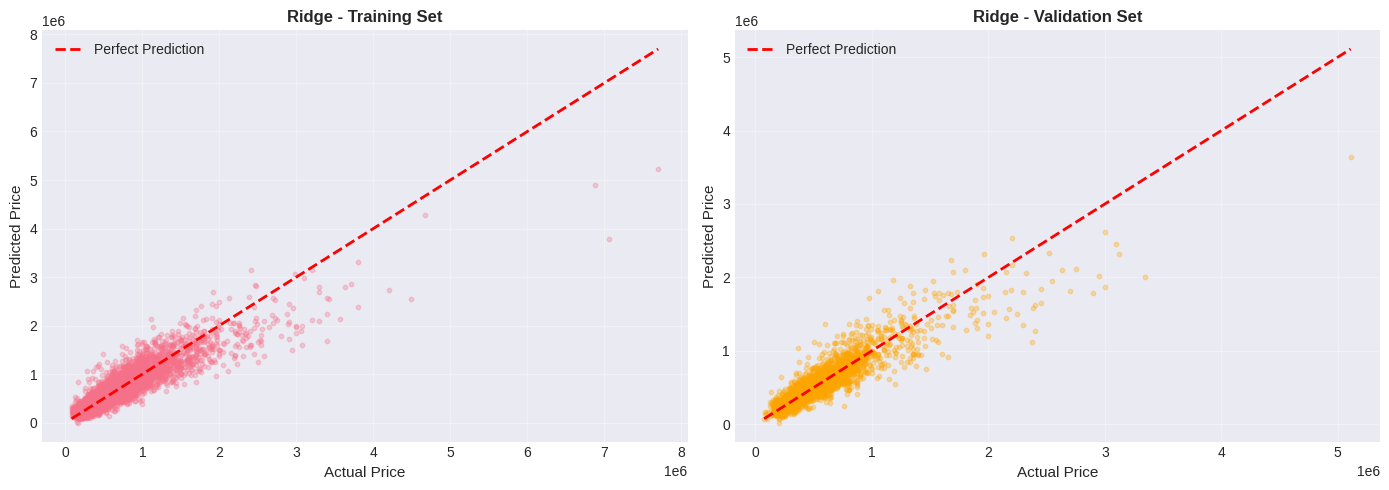


Training Lasso...

Lasso Results:
------------------------------------------------------------
Metric          Train                Validation           Overfit   
------------------------------------------------------------
RMSE            148097.5843          148441.2296          +0.2%     
MAE             90843.5327           92639.0674           +2.0%     
R2              0.8324               0.8244               +0.0080   
MAPE            17.9988              17.8730              -0.7%     


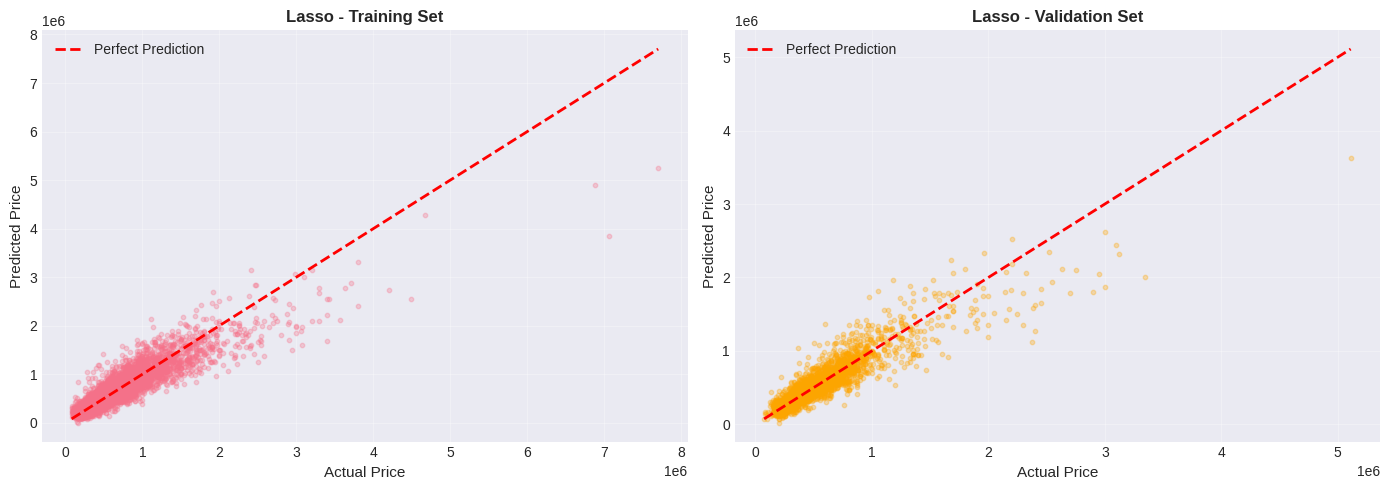


Training ElasticNet...

ElasticNet Results:
------------------------------------------------------------
Metric          Train                Validation           Overfit   
------------------------------------------------------------
RMSE            331664.2017          324627.6142          -2.1%     
MAE             207529.8330          209448.8607          +0.9%     
R2              0.1596               0.1602               -0.0006   
MAPE            47.3831              47.3117              -0.2%     


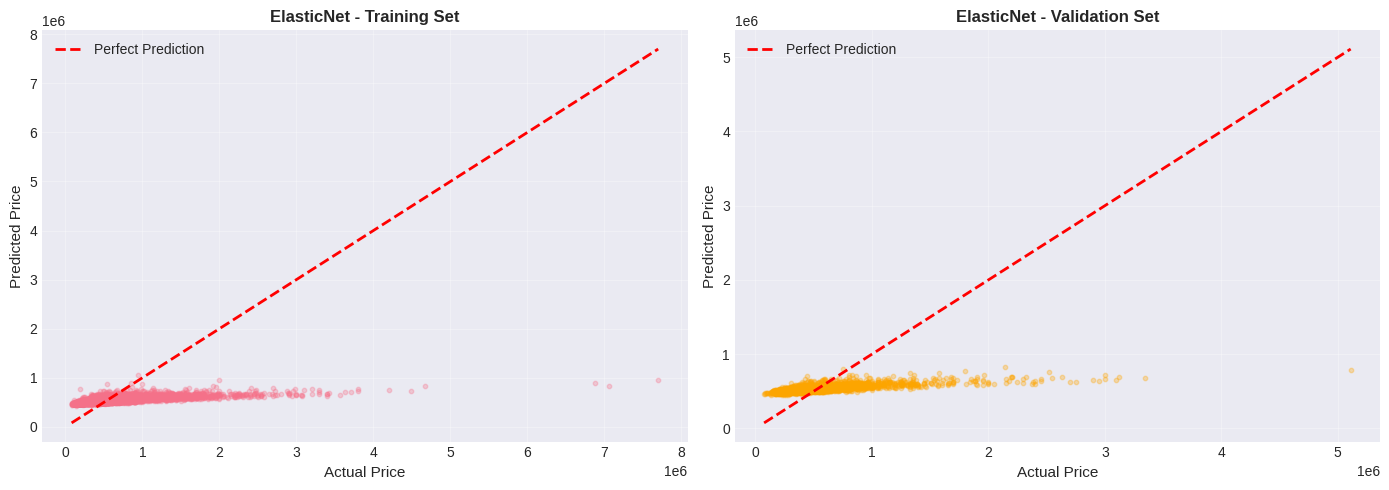


Training Random Forest...

Random Forest Results:
------------------------------------------------------------
Metric          Train                Validation           Overfit   
------------------------------------------------------------
RMSE            47856.1340           125308.9815          +161.8%   
MAE             26836.3504           70284.2952           +161.9%   
R2              0.9825               0.8749               +0.1076   
MAPE            5.2148               13.0751              +150.7%   


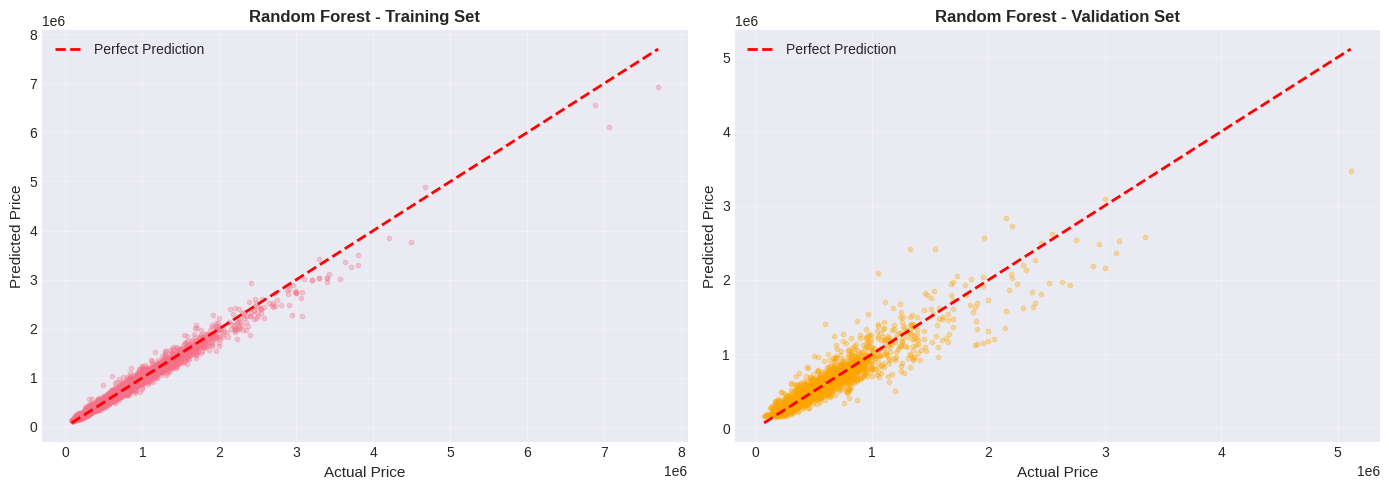


Training Gradient Boosting...

Gradient Boosting Results:
------------------------------------------------------------
Metric          Train                Validation           Overfit   
------------------------------------------------------------
RMSE            74601.4101           114017.1442          +52.8%    
MAE             52083.5834           68152.9119           +30.9%    
R2              0.9575               0.8964               +0.0611   
MAPE            11.0947              12.8141              +15.5%    


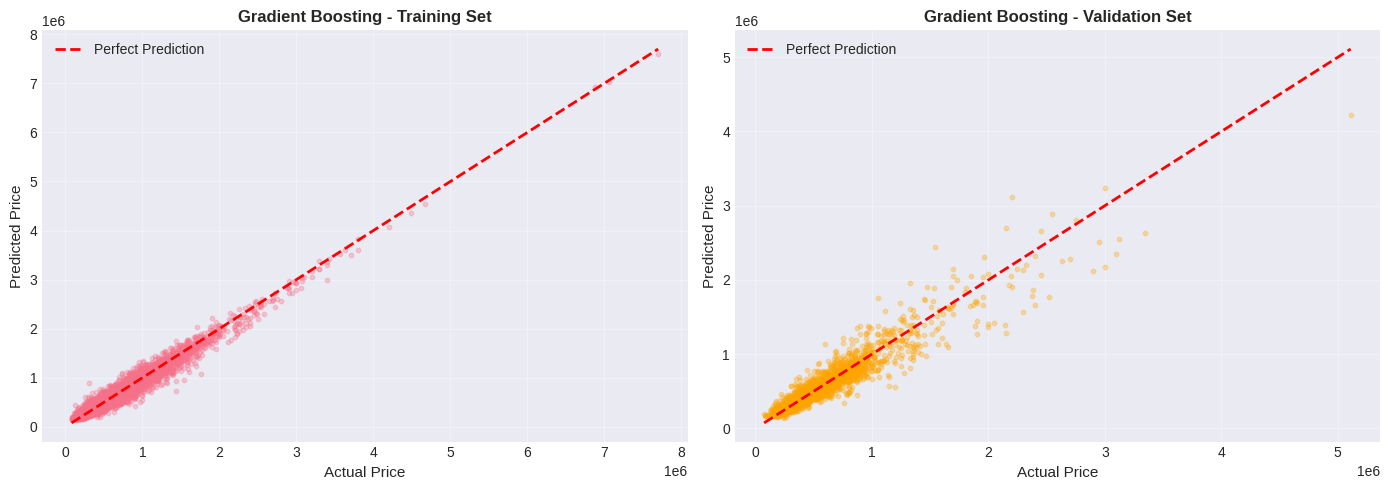


Training XGBoost...

XGBoost Results:
------------------------------------------------------------
Metric          Train                Validation           Overfit   
------------------------------------------------------------
RMSE            55717.9043           127459.0208          +128.8%   
MAE             39907.7344           67970.9688           +70.3%    
R2              0.9763               0.8705               +0.1057   
MAPE            8.9812               12.5827              +40.1%    


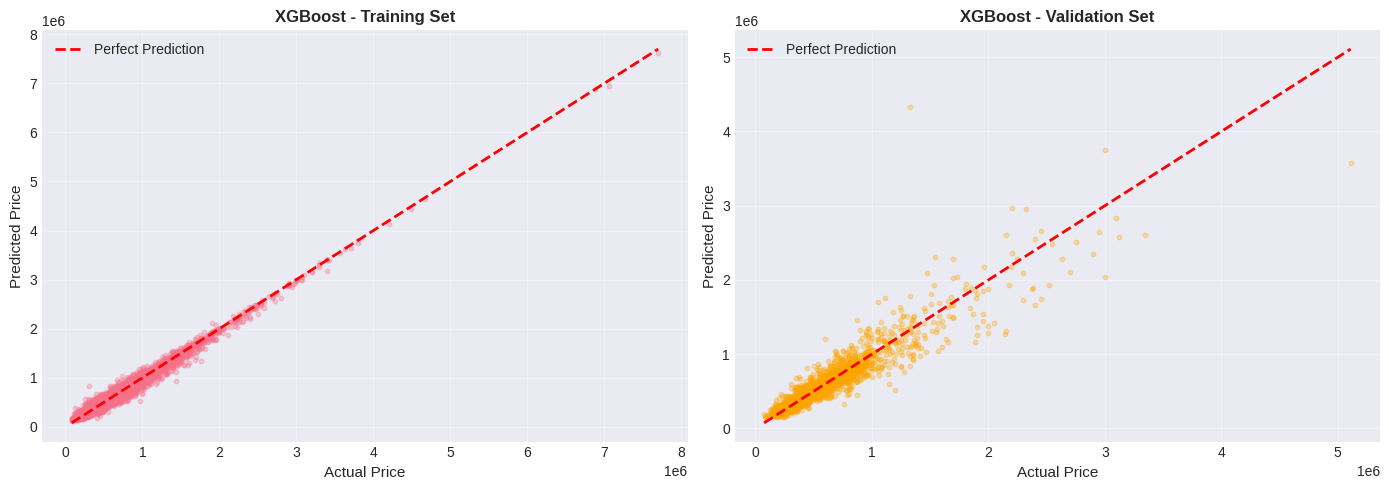


Training LightGBM...

LightGBM Results:
------------------------------------------------------------
Metric          Train                Validation           Overfit   
------------------------------------------------------------
RMSE            86584.5000           114751.9457          +32.5%    
MAE             55187.4755           68543.6086           +24.2%    
R2              0.9427               0.8951               +0.0477   
MAPE            11.4562              12.8654              +12.3%    


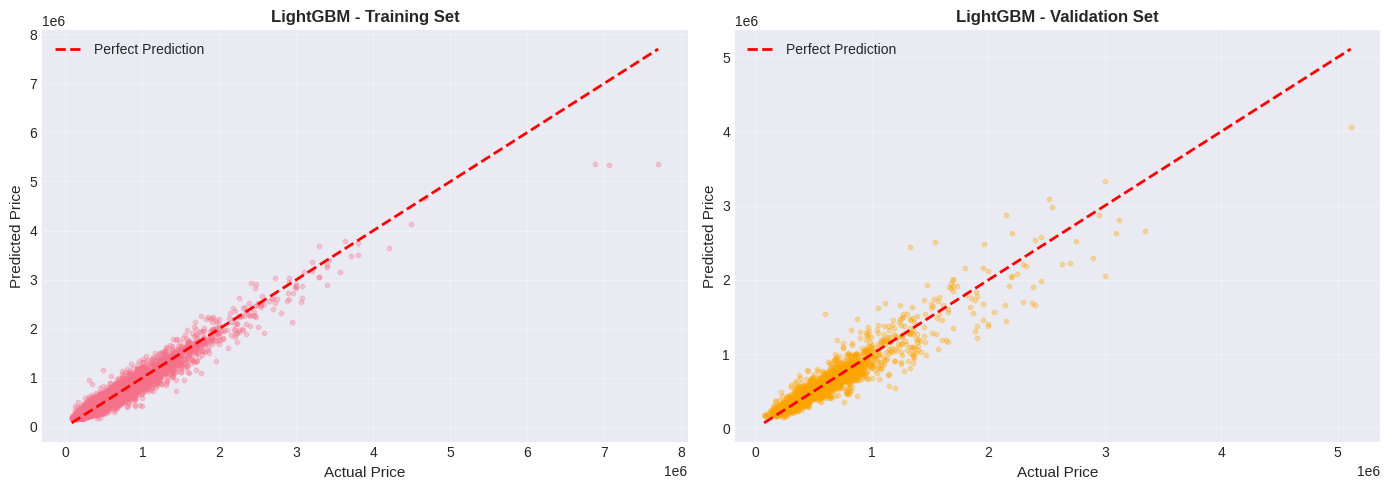


✅ Tabular-only models trained!


In [ ]:
print("="*80)
print("BASELINE MODELS - TABULAR ONLY")
print("="*80)

# Dictionary to store results
tabular_results = {}

# Define models
tabular_models = {
    'Ridge': Ridge(alpha=10.0),
    'Lasso': Lasso(alpha=100.0, max_iter=5000),
    'ElasticNet': ElasticNet(alpha=100.0, l1_ratio=0.5, max_iter=5000),
    'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=20, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, max_depth=7, learning_rate=0.1, random_state=42, n_jobs=-1),
    'LightGBM': LGBMRegressor(n_estimators=100, max_depth=7, learning_rate=0.1, random_state=42, n_jobs=-1, verbose=-1),
}

# Train and evaluate each model
for name, model in tabular_models.items():
    trained_model, train_res, val_res, y_train_pred, y_val_pred = train_and_evaluate_ml_model(
        model, X_train, y_train, X_val, y_val, name
    )

    # Store results
    tabular_results[name] = {
        'model': trained_model,
        'train_metrics': train_res,
        'val_metrics': val_res,
        'y_train_pred': y_train_pred,
        'y_val_pred': y_val_pred
    }

    # Plot predictions
    plot_predictions(y_train, y_train_pred, y_val, y_val_pred, name)

print("\n✅ Tabular-only models trained!")

---
## 5. BASELINE MODELS - IMAGE ONLY (CNN Features)

Train ML models using only CNN-extracted features.

In [ ]:
print("="*80)
print("BASELINE MODELS - IMAGE ONLY (CNN Features)")
print("="*80)

# Dictionary to store results
image_results = {}

# Define models (simpler for high-dimensional CNN features)
image_models = {
    'Ridge (CNN)': Ridge(alpha=100.0),
    'Random Forest (CNN)': RandomForestRegressor(n_estimators=100, max_depth=15, random_state=42, n_jobs=-1),
    'XGBoost (CNN)': XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42, n_jobs=-1),
    'LightGBM (CNN)': LGBMRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42, n_jobs=-1, verbose=-1),
}

# Train and evaluate each model
for name, model in image_models.items():
    trained_model, train_res, val_res, y_train_pred, y_val_pred = train_and_evaluate_ml_model(
        model, X_train_cnn, y_train, X_val_cnn, y_val, name
    )

    # Store results
    image_results[name] = {
        'model': trained_model,
        'train_metrics': train_res,
        'val_metrics': val_res,
        'y_train_pred': y_train_pred,
        'y_val_pred': y_val_pred
    }

    # Plot predictions
    plot_predictions(y_train, y_train_pred, y_val, y_val_pred, name)

print("\n✅ Image-only models trained!")

---
## 6. MULTIMODAL ML MODELS

Train ML models using combined tabular + CNN features.

MULTIMODAL ML MODELS (Tabular + CNN Features)

Training Ridge (Multimodal)...

Ridge (Multimodal) Results:
------------------------------------------------------------
Metric          Train                Validation           Overfit   
------------------------------------------------------------
RMSE            139466.3151          144944.1443          +3.9%     
MAE             86499.2621           91787.8468           +6.1%     
R2              0.8514               0.8326               +0.0188   
MAPE            17.3681              17.9720              +3.5%     


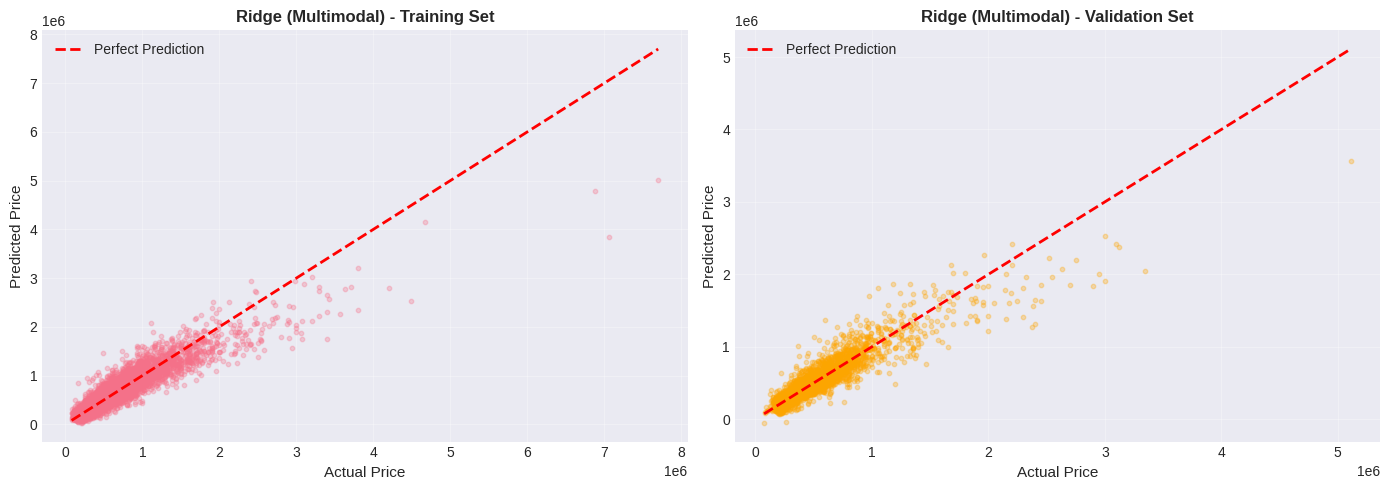


Training XGBoost (Multimodal)...

XGBoost (Multimodal) Results:
------------------------------------------------------------
Metric          Train                Validation           Overfit   
------------------------------------------------------------
RMSE            48745.5565           138403.0816          +183.9%   
MAE             36093.4922           71091.9453           +97.0%    
R2              0.9818               0.8474               +0.1345   
MAPE            8.3965               13.0890              +55.9%    


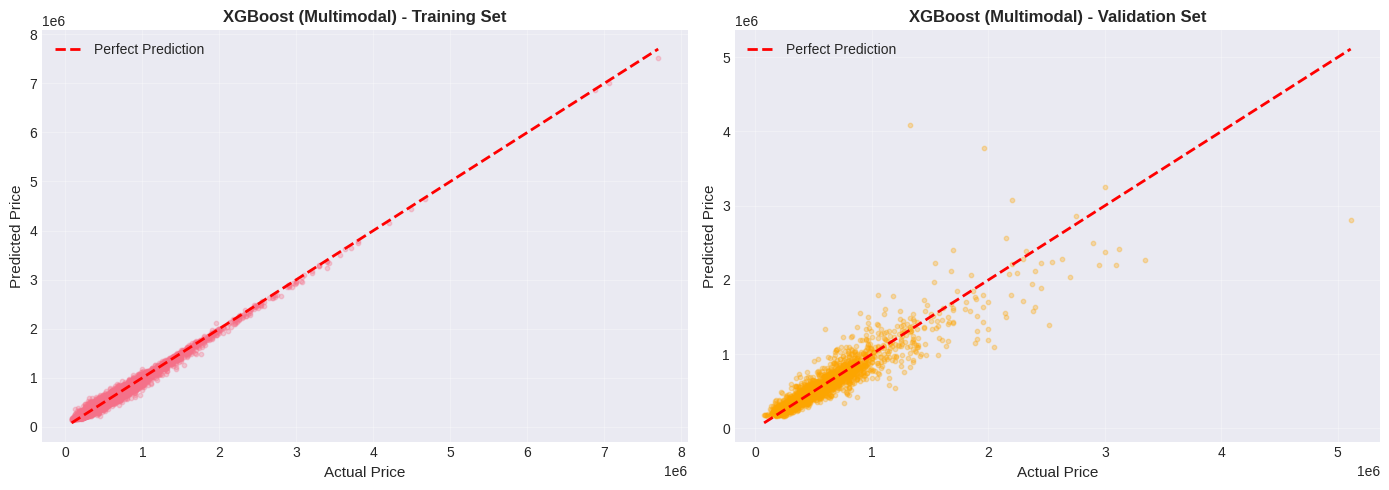


Training LightGBM (Multimodal)...

LightGBM (Multimodal) Results:
------------------------------------------------------------
Metric          Train                Validation           Overfit   
------------------------------------------------------------
RMSE            84091.9058           118572.4574          +41.0%    
MAE             53147.6478           70017.3221           +31.7%    
R2              0.9460               0.8880               +0.0580   
MAPE            11.2558              13.1924              +17.2%    


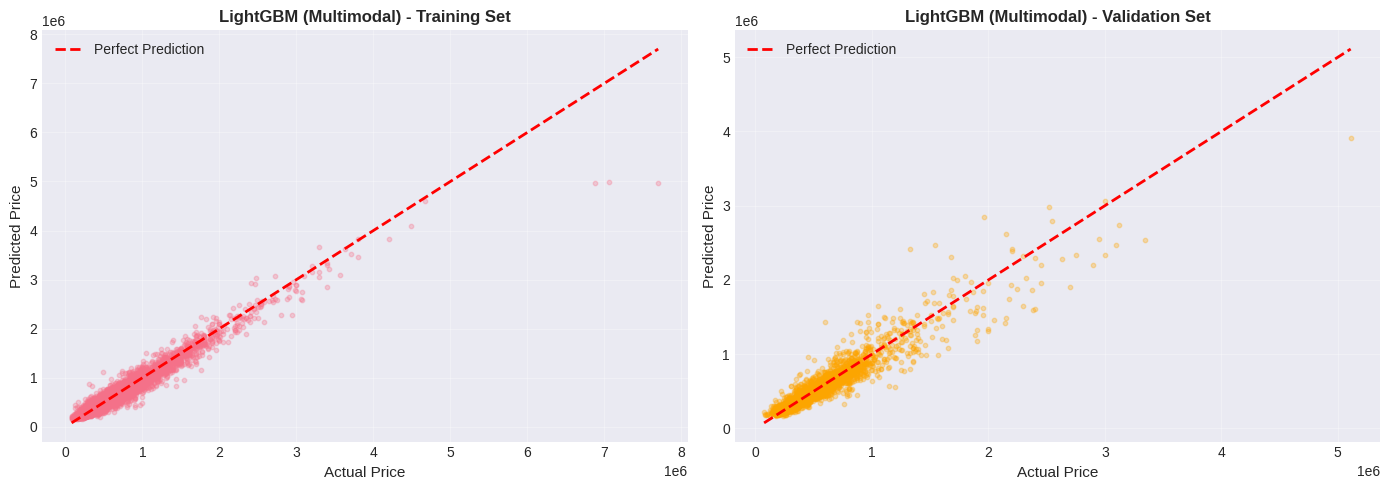


Training CatBoost (Multimodal)...

CatBoost (Multimodal) Results:
------------------------------------------------------------
Metric          Train                Validation           Overfit   
------------------------------------------------------------
RMSE            101570.5679          130169.4205          +28.2%    
MAE             66659.2317           75018.8907           +12.5%    
R2              0.9212               0.8650               +0.0562   
MAPE            13.6501              14.3261              +5.0%     


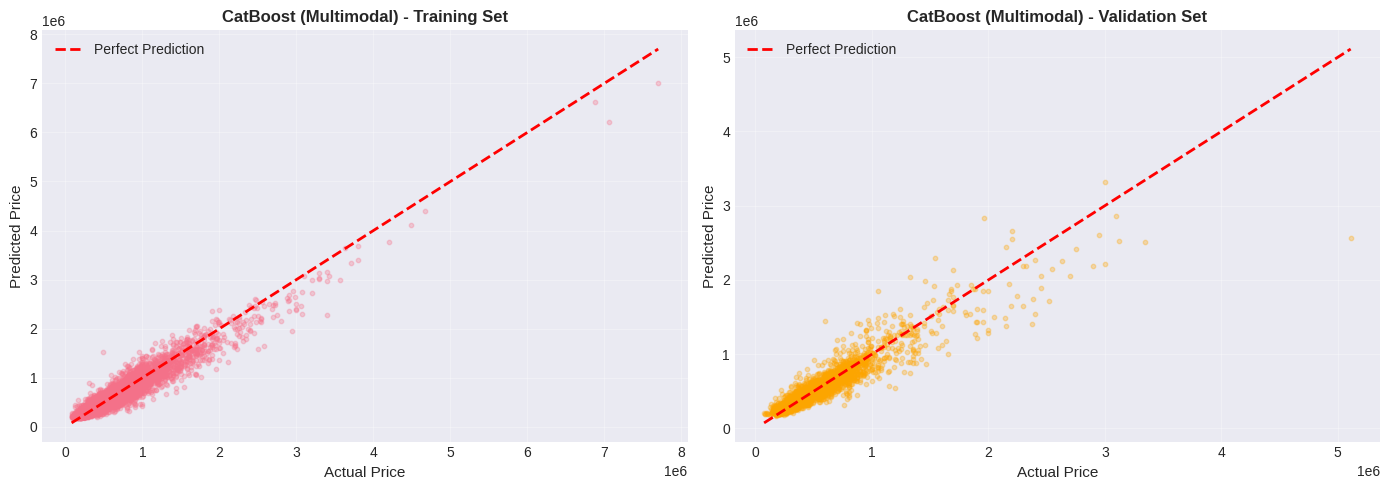


✅ Multimodal ML models trained!


In [ ]:
print("="*80)
print("MULTIMODAL ML MODELS (Tabular + CNN Features)")
print("="*80)

# Dictionary to store results
multimodal_results = {}

# Define models
multimodal_models = {
    'Ridge (Multimodal)': Ridge(alpha=100.0),
    # 'Random Forest (Multimodal)': RandomForestRegressor(n_estimators=150, max_depth=20, random_state=42, n_jobs=-1),
    'XGBoost (Multimodal)': XGBRegressor(n_estimators=150, max_depth=7, learning_rate=0.05, random_state=42, n_jobs=-1),
    'LightGBM (Multimodal)': LGBMRegressor(n_estimators=150, max_depth=7, learning_rate=0.05, random_state=42, n_jobs=-1, verbose=-1),
    'CatBoost (Multimodal)': CatBoostRegressor(iterations=150, depth=7, learning_rate=0.05, random_state=42, verbose=0),
}

# Train and evaluate each model
for name, model in multimodal_models.items():
    trained_model, train_res, val_res, y_train_pred, y_val_pred = train_and_evaluate_ml_model(
        model, X_train_combined, y_train, X_val_combined, y_val, name
    )

    # Store results
    multimodal_results[name] = {
        'model': trained_model,
        'train_metrics': train_res,
        'val_metrics': val_res,
        'y_train_pred': y_train_pred,
        'y_val_pred': y_val_pred
    }

    # Plot predictions
    plot_predictions(y_train, y_train_pred, y_val, y_val_pred, name)

print("\n✅ Multimodal ML models trained!")

---
## 7. COMPARE ML MODELS

Compare all ML models side by side.

In [ ]:
# Compile all results
all_ml_results = []

for name, results in tabular_results.items():
    all_ml_results.append({
        'Model': name,
        'Type': 'Tabular Only',
        'Train RMSE': results['train_metrics']['RMSE'],
        'Val RMSE': results['val_metrics']['RMSE'],
        'Train R2': results['train_metrics']['R2'],
        'Val R2': results['val_metrics']['R2'],
        'Train MAE': results['train_metrics']['MAE'],
        'Val MAE': results['val_metrics']['MAE']
    })

# for name, results in image_results.items():
#     all_ml_results.append({
#         'Model': name,
#         'Type': 'Image Only',
#         'Train RMSE': results['train_metrics']['RMSE'],
#         'Val RMSE': results['val_metrics']['RMSE'],
#         'Train R2': results['train_metrics']['R2'],
#         'Val R2': results['val_metrics']['R2'],
#         'Train MAE': results['train_metrics']['MAE'],
#         'Val MAE': results['val_metrics']['MAE']
#     })

for name, results in multimodal_results.items():
    all_ml_results.append({
        'Model': name,
        'Type': 'Multimodal',
        'Train RMSE': results['train_metrics']['RMSE'],
        'Val RMSE': results['val_metrics']['RMSE'],
        'Train R2': results['train_metrics']['R2'],
        'Val R2': results['val_metrics']['R2'],
        'Train MAE': results['train_metrics']['MAE'],
        'Val MAE': results['val_metrics']['MAE']
    })

# Create comparison dataframe
comparison_df = pd.DataFrame(all_ml_results)
comparison_df = comparison_df.sort_values('Val RMSE')

print("\n" + "="*80)
print("ML MODELS COMPARISON (Sorted by Val RMSE)")
print("="*80)
print(comparison_df.to_string(index=False))

# Find best model
best_model_name = comparison_df.iloc[0]['Model']
best_model_type = comparison_df.iloc[0]['Type']
print(f"\n🏆 Best ML Model: {best_model_name} ({best_model_type})")
print(f"   Validation RMSE: ${comparison_df.iloc[0]['Val RMSE']:,.2f}")
print(f"   Validation R²: {comparison_df.iloc[0]['Val R2']:.4f}")


ML MODELS COMPARISON (Sorted by Val RMSE)
                Model         Type    Train RMSE      Val RMSE  Train R2   Val R2     Train MAE       Val MAE
    Gradient Boosting Tabular Only  74601.410131 114017.144172  0.957480 0.896406  52083.583448  68152.911900
             LightGBM Tabular Only  86584.499973 114751.945745  0.942723 0.895066  55187.475506  68543.608589
LightGBM (Multimodal)   Multimodal  84091.905779 118572.457377  0.945974 0.887963  53147.647784  70017.322132
        Random Forest Tabular Only  47856.134028 125308.981544  0.982503 0.874870  26836.350369  70284.295246
              XGBoost Tabular Only  55717.904340 127459.020803  0.976282 0.870540  39907.734375  67970.968750
CatBoost (Multimodal)   Multimodal 101570.567854 130169.420470  0.921181 0.864975  66659.231664  75018.890666
 XGBoost (Multimodal)   Multimodal  48745.556515 138403.081584  0.981846 0.847353  36093.492188  71091.945312
   Ridge (Multimodal)   Multimodal 139466.315083 144944.144330  0.851394 0.83

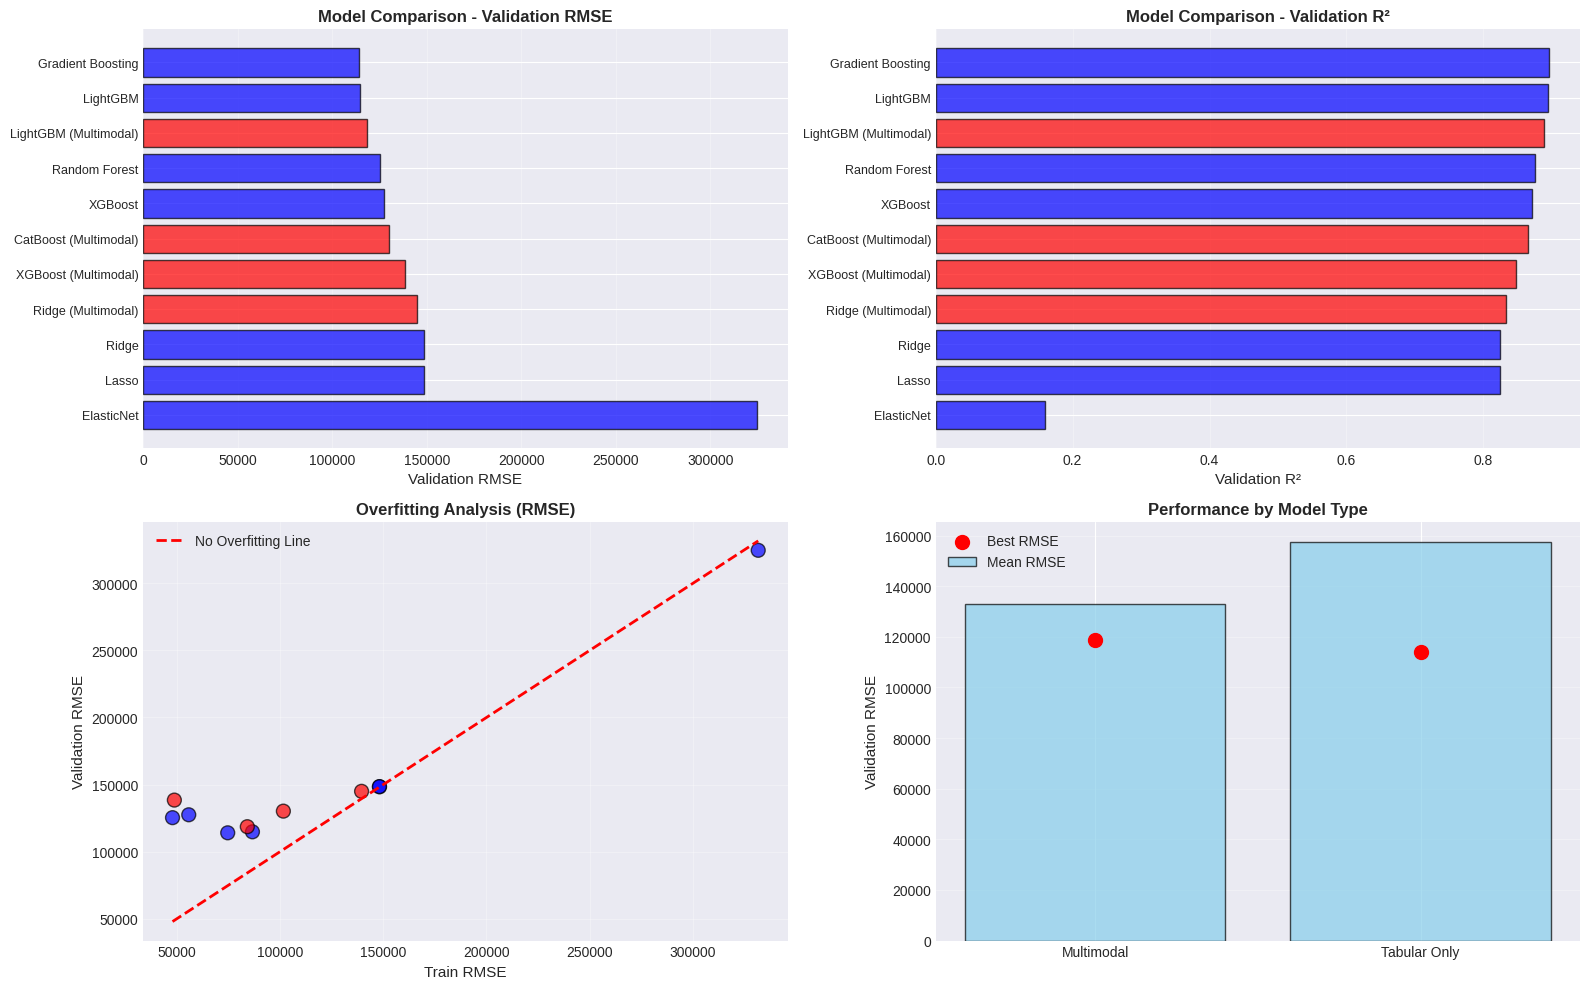

In [ ]:
# Visualize comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Plot 1: Val RMSE by model type
comparison_df_plot = comparison_df.copy()
colors = {'Tabular Only': 'blue', 'Image Only': 'green', 'Multimodal': 'red'}
comparison_df_plot['Color'] = comparison_df_plot['Type'].map(colors)

axes[0, 0].barh(range(len(comparison_df_plot)), comparison_df_plot['Val RMSE'],
                color=comparison_df_plot['Color'], alpha=0.7, edgecolor='black')
axes[0, 0].set_yticks(range(len(comparison_df_plot)))
axes[0, 0].set_yticklabels(comparison_df_plot['Model'], fontsize=9)
axes[0, 0].set_xlabel('Validation RMSE', fontsize=11)
axes[0, 0].set_title('Model Comparison - Validation RMSE', fontsize=12, fontweight='bold')
axes[0, 0].invert_yaxis()
axes[0, 0].grid(axis='x', alpha=0.3)

# Plot 2: Val R2 by model type
axes[0, 1].barh(range(len(comparison_df_plot)), comparison_df_plot['Val R2'],
                color=comparison_df_plot['Color'], alpha=0.7, edgecolor='black')
axes[0, 1].set_yticks(range(len(comparison_df_plot)))
axes[0, 1].set_yticklabels(comparison_df_plot['Model'], fontsize=9)
axes[0, 1].set_xlabel('Validation R²', fontsize=11)
axes[0, 1].set_title('Model Comparison - Validation R²', fontsize=12, fontweight='bold')
axes[0, 1].invert_yaxis()
axes[0, 1].grid(axis='x', alpha=0.3)

# Plot 3: Train vs Val RMSE (Overfitting check)
axes[1, 0].scatter(comparison_df_plot['Train RMSE'], comparison_df_plot['Val RMSE'],
                   c=comparison_df_plot['Color'], s=100, alpha=0.7, edgecolor='black')
axes[1, 0].plot([comparison_df_plot['Train RMSE'].min(), comparison_df_plot['Train RMSE'].max()],
                [comparison_df_plot['Train RMSE'].min(), comparison_df_plot['Train RMSE'].max()],
                'r--', lw=2, label='No Overfitting Line')
axes[1, 0].set_xlabel('Train RMSE', fontsize=11)
axes[1, 0].set_ylabel('Validation RMSE', fontsize=11)
axes[1, 0].set_title('Overfitting Analysis (RMSE)', fontsize=12, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Model type performance
type_performance = comparison_df.groupby('Type')['Val RMSE'].agg(['mean', 'min']).reset_index()
x = range(len(type_performance))
axes[1, 1].bar(x, type_performance['mean'], alpha=0.7, label='Mean RMSE', color='skyblue', edgecolor='black')
axes[1, 1].scatter(x, type_performance['min'], s=100, color='red', label='Best RMSE', zorder=5)
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(type_performance['Type'])
axes[1, 1].set_ylabel('Validation RMSE', fontsize=11)
axes[1, 1].set_title('Performance by Model Type', fontsize=12, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

---
## 8. DEEP LEARNING MODELS

Build end-to-end multimodal deep learning models.

### 8.1 Custom Dataset for DL

In [6]:
import numpy as np
from sklearn.preprocessing import StandardScaler
import os # Import the os module

# Ensure the directory exists before saving files
os.makedirs('./processed_data', exist_ok=True)

# === CRITICAL: NORMALIZE PRICES ===
print("="*80)
print("NORMALIZING PRICES")
print("="*80)

# Log transform (prices are naturally log-distributed)
train_df['price_log'] = np.log1p(train_df['price'])
val_df['price_log'] = np.log1p(val_df['price'])

# Fit on training data
price_log_mean = train_df['price_log'].mean()
price_log_std = train_df['price_log'].std()

# Normalize
train_df['price_normalized'] = (train_df['price_log'] - price_log_mean) / price_log_std
val_df['price_normalized'] = (val_df['price_log'] - price_log_mean) / price_log_std

print(f"Original prices:")
print(f"  Train: ${train_df['price'].min():,.0f} to ${train_df['price'].max():,.0f}")
print(f"  Val:   ${val_df['price'].min():,.0f} to ${val_df['price'].max():,.0f}")
print(f"\nNormalized prices:")
print(f"  Train: {train_df['price_normalized'].min():.2f} to {train_df['price_normalized'].max():.2f}")
print(f"  Val:   {val_df['price_normalized'].min():.2f} to {val_df['price_normalized'].max():.2f}")
print(f"\nNormalization params:")
print(f"  Mean: {price_log_mean:.4f}")
print(f"  Std:  {price_log_std:.4f}")

# Save for later use
np.save('./processed_data/price_log_mean.npy', price_log_mean)
np.save('./processed_data/price_log_std.npy', price_log_std)

NORMALIZING PRICES
Original prices:
  Train: $80,000 to $7,700,000
  Val:   $75,000 to $5,110,800

Normalized prices:
  Train: -3.35 to 5.37
  Val:   -3.47 to 4.59

Normalization params:
  Mean: 13.0440
  Std:  0.5235


In [7]:
def denormalize_price(price_normalized, price_log_mean, price_log_std):
    """
    Convert normalized predictions back to actual dollar amounts

    Args:
        price_normalized: Normalized price values (z-scores)
        price_log_mean: Mean of log(price) from training set
        price_log_std: Std of log(price) from training set

    Returns:
        price: Actual dollar amounts
    """
    # Step 1: Reverse standardization
    price_log = price_normalized * price_log_std + price_log_mean

    # Step 2: Reverse log transform
    price = np.expm1(price_log)  # exp(x) - 1, inverse of log1p

    return price

In [8]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ✅ Add resize here
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGE_MEAN, std=IMAGE_STD)
])

In [9]:
from PIL import Image

In [10]:
class MultimodalDataset(Dataset):
    """
    Dataset that returns both images and tabular features
    WITH NORMALIZED PRICES
    """
    def __init__(self, df, image_dir, tabular_features, image_col='image_name', transform=None):
        self.df = df.reset_index(drop=True)
        self.image_dir = image_dir
        self.tabular_features = tabular_features
        self.image_col = image_col
        self.transform = transform

        # Find valid indices
        self.valid_indices = []
        for idx in range(len(self.df)):
            img_path = os.path.join(self.image_dir, self.df.loc[idx, self.image_col])
            if os.path.exists(img_path):
                self.valid_indices.append(idx)

        print(f"Dataset initialized: {len(self.valid_indices)}/{len(self.df)} valid samples")

    def __len__(self):
        return len(self.valid_indices)

    def __getitem__(self, idx):
        actual_idx = self.valid_indices[idx]

        # Load image
        img_name = self.df.loc[actual_idx, self.image_col]
        img_path = os.path.join(self.image_dir, img_name)

        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        # Get tabular features
        tabular = self.df.loc[actual_idx, self.tabular_features].values.astype(np.float32)
        tabular = torch.tensor(tabular, dtype=torch.float32)

        # *** CRITICAL CHANGE: Use normalized price ***
        target = torch.tensor(self.df.loc[actual_idx, 'price_normalized'], dtype=torch.float32)

        return {
            'image': image,
            'tabular': tabular,
            'target': target
        }

# Create datasets
train_dataset = MultimodalDataset(train_df, TRAIN_IMAGE_DIR, SELECTED_FEATURES, transform=train_transform)
val_dataset = MultimodalDataset(val_df, TRAIN_IMAGE_DIR, SELECTED_FEATURES, transform=train_transform)

# Define DataLoaders
val_loader_dl = DataLoader(
    val_dataset,
    batch_size=64,          # ✅ Use same batch size as train_loader_dl for consistency
    shuffle=False,          # Validation data should not be shuffled
    num_workers=8,          # ✅ Use same number of workers as train_loader_dl
    pin_memory=True,        # ✅ ADD: Faster CPU→GPU transfer
    persistent_workers=True # ✅ ADD: Keep workers alive between epochs
)

train_loader_dl = DataLoader(
    train_dataset,
    batch_size=64,          # ✅ DOUBLE: 32→64 (use GPU memory better)
    shuffle=True,
    num_workers=8,          # ✅ DOUBLE: 2→4 (more parallel loading)
    pin_memory=True,        # ✅ ADD: Faster CPU→GPU transfer
    persistent_workers=True # ✅ ADD: Keep workers alive between epochs
)

print(f"\nTrain dataset: {len(train_dataset)} samples")
print(f"Val dataset: {len(val_dataset)} samples")
print(f"Train batches: {len(train_loader_dl)}")
print(f"Val batches: {len(val_loader_dl)}")

Dataset initialized: 12967/12967 valid samples
Dataset initialized: 3242/3242 valid samples

Train dataset: 12967 samples
Val dataset: 3242 samples
Train batches: 203
Val batches: 51


### 8.2 Define Multimodal Architecture

In [11]:
class MultimodalPricePredictor(nn.Module):
    """
    Multimodal architecture combining CNN (images) and MLP (tabular)

    Architecture:
    - Image branch: ResNet50 backbone → 2048 features
    - Tabular branch: MLP → 128 features
    - Fusion: Concatenate → Final MLP → Price prediction
    """
    def __init__(self, num_tabular_features, dropout=0.3):
        super(MultimodalPricePredictor, self).__init__()

        # Image branch (ResNet50)
        resnet = models.resnet50(pretrained=True)
        # Remove final FC layer
        self.image_features = nn.Sequential(*list(resnet.children())[:-1])

        # Fine-tune only last few layers

        for param in self.image_features.parameters():
            param.requires_grad = False
        # Image branch head
        # self.image_head = nn.Sequential(
        #     nn.Linear(2048, 512),
        #     nn.BatchNorm1d(512),
        #     nn.ReLU(),
        #     nn.Dropout(dropout),
        #     nn.Linear(512, 256)
        # )
        self.image_head = nn.Sequential(
            nn.Linear(2048, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, 128)
        )


        # Tabular branch
        self.tabular_branch = nn.Sequential(
            nn.Linear(num_tabular_features, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, 64)
        )

        # Fusion layer
        # fusion_input = 256 + 64  # image_head + tabular_branch
        fusion_input = 128 + 64  # image + tabular

        self.fusion = nn.Sequential(
            nn.Linear(fusion_input, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(dropout / 2),
            nn.Linear(128, 1)
        )

    def forward(self, image, tabular):
        # Image branch
        x_img = self.image_features(image)
        x_img = torch.flatten(x_img, 1)
        x_img = self.image_head(x_img)

        # Tabular branch
        x_tab = self.tabular_branch(tabular)

        # Fusion
        x_combined = torch.cat([x_img, x_tab], dim=1)
        output = self.fusion(x_combined)

        return output.squeeze()

# Initialize model
model_dl = MultimodalPricePredictor(num_tabular_features=len(SELECTED_FEATURES)).to(device)

# Count parameters
total_params = sum(p.numel() for p in model_dl.parameters())
trainable_params = sum(p.numel() for p in model_dl.parameters() if p.requires_grad)

print(f"\n✅ Multimodal model initialized!")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 187MB/s]



✅ Multimodal model initialized!
Total parameters: 24,199,553
Trainable parameters: 691,521


### 8.3 Training Loop with Evaluation

In [12]:
from torch.cuda.amp import autocast, GradScaler

In [9]:
def train_dl_model(model, train_loader, val_loader, epochs=20, lr=0.001,
                   price_log_mean=None, price_log_std=None):
    """
    Train deep learning model with PROPER price normalization
    """
    criterion = nn.MSELoss()
    # optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    optimizer = torch.optim.Adam([
    # CNN backbone (very small LR or frozen)
    {'params': model.image_features.parameters(), 'lr': 1e-5},

    # Image head
    {'params': model.image_head.parameters(), 'lr': 1e-4},

    # Tabular branch
    {'params': model.tabular_branch.parameters(), 'lr': 1e-3},

    # Fusion layers
    {'params': model.fusion.parameters(), 'lr': 1e-3}
    ], weight_decay=1e-4)

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3
    )

    history = {
        'train_loss': [], 'val_loss': [],
        'train_rmse': [], 'val_rmse': [],
        'train_mae': [], 'val_mae': [],
        'train_r2': [], 'val_r2': []
    }

    best_val_loss = float('inf')
    best_model_state = None
    patience_counter = 0
    early_stop_patience = 8

    print("\n" + "="*80)
    print("TRAINING DEEP LEARNING MODEL (WITH PRICE NORMALIZATION)")
    print("="*80)

    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        print("-" * 60)

        # ===== TRAINING =====
        model.train()
        train_loss = 0.0
        train_preds_norm = []
        train_targets_norm = []

        train_pbar = tqdm(train_loader, desc="Training")
        for batch in train_pbar:
            images = batch['image'].to(device)
            tabular = batch['tabular'].to(device)
            targets = batch['target'].to(device)  # Normalized prices



            # Forward pass
            optimizer.zero_grad()
            outputs = model(images, tabular)  # ✅ No autocast
            loss = criterion(outputs, targets)

            # Backward pass
            loss.backward()  # ✅ Normal backward
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()  # ✅ Normal step

            train_loss += loss.item()
            train_preds_norm.extend(outputs.detach().cpu().numpy())
            train_targets_norm.extend(targets.detach().cpu().numpy())

            train_pbar.set_postfix({'loss': f"{loss.item():.4f}"})

        # Calculate train metrics
        train_loss /= len(train_loader)
        train_preds_norm = np.array(train_preds_norm)
        train_targets_norm = np.array(train_targets_norm)

        # *** DENORMALIZE for interpretable metrics ***
        train_preds = denormalize_price(train_preds_norm, price_log_mean, price_log_std)
        train_targets = denormalize_price(train_targets_norm, price_log_mean, price_log_std)

        train_rmse = np.sqrt(mean_squared_error(train_targets, train_preds))
        train_mae = mean_absolute_error(train_targets, train_preds)
        train_r2 = r2_score(train_targets, train_preds)

        # ===== VALIDATION =====
        model.eval()
        val_loss = 0.0
        val_preds_norm = []
        val_targets_norm = []

        with torch.no_grad():
            val_pbar = tqdm(val_loader, desc="Validation")
            for batch in val_pbar:
                images = batch['image'].to(device)
                tabular = batch['tabular'].to(device)
                targets = batch['target'].to(device)

                outputs = model(images, tabular)
                loss = criterion(outputs, targets)

                val_loss += loss.item()
                val_preds_norm.extend(outputs.cpu().numpy())
                val_targets_norm.extend(targets.cpu().numpy())

                val_pbar.set_postfix({'loss': f"{loss.item():.4f}"})

        # Calculate val metrics
        val_loss /= len(val_loader)
        val_preds_norm = np.array(val_preds_norm)
        val_targets_norm = np.array(val_targets_norm)

        # *** DENORMALIZE for interpretable metrics ***
        val_preds = denormalize_price(val_preds_norm, price_log_mean, price_log_std)
        val_targets = denormalize_price(val_targets_norm, price_log_mean, price_log_std)

        val_rmse = np.sqrt(mean_squared_error(val_targets, val_preds))
        val_mae = mean_absolute_error(val_targets, val_preds)
        val_r2 = r2_score(val_targets, val_preds)

        # Update history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_rmse'].append(train_rmse)
        history['val_rmse'].append(val_rmse)
        history['train_mae'].append(train_mae)
        history['val_mae'].append(val_mae)
        history['train_r2'].append(train_r2)
        history['val_r2'].append(val_r2)

        # Print epoch summary
        print(f"\nEpoch {epoch+1} Summary:")
        print(f"{'Metric':<15} {'Train':<20} {'Validation':<20}")
        print("-" * 55)
        print(f"{'Loss (Norm)':<15} {train_loss:<20.4f} {val_loss:<20.4f}")
        print(f"{'RMSE ($)':<15} {train_rmse:<20.2f} {val_rmse:<20.2f}")
        print(f"{'MAE ($)':<15} {train_mae:<20.2f} {val_mae:<20.2f}")
        print(f"{'R²':<15} {train_r2:<20.4f} {val_r2:<20.4f}")

        # Learning rate scheduling
        scheduler.step(val_loss)

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict().copy()
            patience_counter = 0
            print(f"✓ New best model! Val Loss: {val_loss:.4f}")
        else:
            patience_counter += 1

        # Early stopping
        if patience_counter >= early_stop_patience:
            print(f"\nEarly stopping triggered after {epoch+1} epochs")
            break

    # Load best model
    model.load_state_dict(best_model_state)
    print(f"\n✅ Training complete! Best Val Loss: {best_val_loss:.4f}")

    return model, history

### 8.4 Train the Model

In [13]:
# Initialize fresh model
model_dl = MultimodalPricePredictor(num_tabular_features=len(SELECTED_FEATURES)).to(device)

# Train with corrected normalization
trained_model_dl, history_dl = train_dl_model(
    model_dl,
    train_loader_dl,
    val_loader_dl,
    epochs=20,
    lr=0.001,  # Standard learning rate
    price_log_mean=price_log_mean,
    price_log_std=price_log_std
)

# Save model
os.makedirs('./models', exist_ok=True)
torch.save({
    'model_state_dict': trained_model_dl.state_dict(),
    'price_log_mean': price_log_mean,
    'price_log_std': price_log_std,
}, './models/best_multimodal_model.pth')
print("\n✅ Model saved to ./models/best_multimodal_model.pth")


TRAINING DEEP LEARNING MODEL (WITH PRICE NORMALIZATION)

Epoch 1/20
------------------------------------------------------------


Validation: 100%|██████████| 51/51 [02:48<00:00,  3.31s/it, loss=0.1557]



Epoch 1 Summary:
Metric          Train                Validation          
-------------------------------------------------------
Loss (Norm)     0.2770               0.1376              
RMSE ($)        213153.79            138359.22           
MAE ($)         115897.91            81068.27            
R²              0.6529               0.8475              
✓ New best model! Val Loss: 0.1376

Epoch 2/20
------------------------------------------------------------


Validation: 100%|██████████| 51/51 [00:38<00:00,  1.33it/s, loss=0.1745]



Epoch 2 Summary:
Metric          Train                Validation          
-------------------------------------------------------
Loss (Norm)     0.1816               0.1388              
RMSE ($)        181060.86            149049.60           
MAE ($)         95122.27             81630.11            
R²              0.7495               0.8230              

Epoch 3/20
------------------------------------------------------------


Validation: 100%|██████████| 51/51 [00:37<00:00,  1.35it/s, loss=0.1433]



Epoch 3 Summary:
Metric          Train                Validation          
-------------------------------------------------------
Loss (Norm)     0.1674               0.1269              
RMSE ($)        176778.02            145355.07           
MAE ($)         92252.55             79852.04            
R²              0.7612               0.8316              
✓ New best model! Val Loss: 0.1269

Epoch 4/20
------------------------------------------------------------


Validation: 100%|██████████| 51/51 [00:39<00:00,  1.30it/s, loss=0.1439]



Epoch 4 Summary:
Metric          Train                Validation          
-------------------------------------------------------
Loss (Norm)     0.1569               0.1233              
RMSE ($)        169805.11            127244.44           
MAE ($)         88802.41             74547.45            
R²              0.7797               0.8710              
✓ New best model! Val Loss: 0.1233

Epoch 5/20
------------------------------------------------------------


Validation: 100%|██████████| 51/51 [00:39<00:00,  1.29it/s, loss=0.1419]



Epoch 5 Summary:
Metric          Train                Validation          
-------------------------------------------------------
Loss (Norm)     0.1519               0.1218              
RMSE ($)        157707.87            127830.83           
MAE ($)         86220.36             74404.59            
R²              0.8100               0.8698              
✓ New best model! Val Loss: 0.1218

Epoch 6/20
------------------------------------------------------------


Validation: 100%|██████████| 51/51 [00:39<00:00,  1.30it/s, loss=0.1343]



Epoch 6 Summary:
Metric          Train                Validation          
-------------------------------------------------------
Loss (Norm)     0.1502               0.1198              
RMSE ($)        163253.84            129758.04           
MAE ($)         86756.41             74820.12            
R²              0.7964               0.8658              
✓ New best model! Val Loss: 0.1198

Epoch 7/20
------------------------------------------------------------


Validation: 100%|██████████| 51/51 [00:38<00:00,  1.33it/s, loss=0.1320]



Epoch 7 Summary:
Metric          Train                Validation          
-------------------------------------------------------
Loss (Norm)     0.1421               0.1210              
RMSE ($)        156099.19            123501.23           
MAE ($)         84160.98             74398.37            
R²              0.8138               0.8785              

Epoch 8/20
------------------------------------------------------------


Validation: 100%|██████████| 51/51 [00:37<00:00,  1.38it/s, loss=0.1614]



Epoch 8 Summary:
Metric          Train                Validation          
-------------------------------------------------------
Loss (Norm)     0.1376               0.1294              
RMSE ($)        158189.15            139097.42           
MAE ($)         83303.45             77920.47            
R²              0.8088               0.8458              

Epoch 9/20
------------------------------------------------------------


Validation: 100%|██████████| 51/51 [00:36<00:00,  1.38it/s, loss=0.1534]



Epoch 9 Summary:
Metric          Train                Validation          
-------------------------------------------------------
Loss (Norm)     0.1289               0.1244              
RMSE ($)        151121.94            122181.41           
MAE ($)         80427.83             74254.41            
R²              0.8255               0.8810              

Epoch 10/20
------------------------------------------------------------


Validation: 100%|██████████| 51/51 [00:39<00:00,  1.30it/s, loss=0.1381]



Epoch 10 Summary:
Metric          Train                Validation          
-------------------------------------------------------
Loss (Norm)     0.1336               0.1180              
RMSE ($)        148614.19            124495.79           
MAE ($)         81047.85             74524.74            
R²              0.8313               0.8765              
✓ New best model! Val Loss: 0.1180

Epoch 11/20
------------------------------------------------------------


Validation: 100%|██████████| 51/51 [00:38<00:00,  1.32it/s, loss=0.1317]



Epoch 11 Summary:
Metric          Train                Validation          
-------------------------------------------------------
Loss (Norm)     0.1303               0.1212              
RMSE ($)        152494.14            125675.72           
MAE ($)         81595.60             74894.59            
R²              0.8223               0.8741              

Epoch 12/20
------------------------------------------------------------


Validation: 100%|██████████| 51/51 [00:37<00:00,  1.35it/s, loss=0.1506]



Epoch 12 Summary:
Metric          Train                Validation          
-------------------------------------------------------
Loss (Norm)     0.1256               0.1320              
RMSE ($)        151215.17            141144.69           
MAE ($)         80319.55             79562.00            
R²              0.8253               0.8412              

Epoch 13/20
------------------------------------------------------------


Validation: 100%|██████████| 51/51 [00:37<00:00,  1.35it/s, loss=0.1491]



Epoch 13 Summary:
Metric          Train                Validation          
-------------------------------------------------------
Loss (Norm)     0.1202               0.1266              
RMSE ($)        158601.31            131192.36           
MAE ($)         78918.24             76583.74            
R²              0.8078               0.8628              

Epoch 14/20
------------------------------------------------------------


Validation: 100%|██████████| 51/51 [00:39<00:00,  1.30it/s, loss=0.1333]



Epoch 14 Summary:
Metric          Train                Validation          
-------------------------------------------------------
Loss (Norm)     0.1185               0.1207              
RMSE ($)        151056.20            128376.55           
MAE ($)         78156.04             74609.23            
R²              0.8257               0.8687              

Epoch 15/20
------------------------------------------------------------


Validation: 100%|██████████| 51/51 [00:38<00:00,  1.31it/s, loss=0.1609]



Epoch 15 Summary:
Metric          Train                Validation          
-------------------------------------------------------
Loss (Norm)     0.1095               0.1302              
RMSE ($)        145395.72            132221.63           
MAE ($)         76053.61             77602.97            
R²              0.8385               0.8607              

Epoch 16/20
------------------------------------------------------------


Validation: 100%|██████████| 51/51 [00:38<00:00,  1.33it/s, loss=0.1540]



Epoch 16 Summary:
Metric          Train                Validation          
-------------------------------------------------------
Loss (Norm)     0.1047               0.1204              
RMSE ($)        139528.77            129469.36           
MAE ($)         73497.71             74488.32            
R²              0.8513               0.8664              

Epoch 17/20
------------------------------------------------------------


Validation: 100%|██████████| 51/51 [00:37<00:00,  1.36it/s, loss=0.1428]



Epoch 17 Summary:
Metric          Train                Validation          
-------------------------------------------------------
Loss (Norm)     0.1035               0.1240              
RMSE ($)        134205.10            127365.50           
MAE ($)         73404.80             75067.84            
R²              0.8624               0.8707              

Epoch 18/20
------------------------------------------------------------


Validation: 100%|██████████| 51/51 [00:38<00:00,  1.34it/s, loss=0.1410]



Epoch 18 Summary:
Metric          Train                Validation          
-------------------------------------------------------
Loss (Norm)     0.1017               0.1310              
RMSE ($)        142521.14            130971.98           
MAE ($)         73236.22             77423.12            
R²              0.8448               0.8633              

Early stopping triggered after 18 epochs

✅ Training complete! Best Val Loss: 0.1180

✅ Model saved to ./models/best_multimodal_model.pth


In [14]:
def evaluate_dl_model_final(model, data_loader, price_log_mean, price_log_std):
    """
    Final evaluation with denormalized metrics
    """
    model.eval()
    all_preds_norm = []
    all_targets_norm = []

    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluating"):
            images = batch['image'].to(device)
            tabular = batch['tabular'].to(device)
            targets = batch['target']  # Keep on CPU

            outputs = model(images, tabular)

            all_preds_norm.extend(outputs.cpu().numpy())
            all_targets_norm.extend(targets.numpy())

    # Convert to numpy
    all_preds_norm = np.array(all_preds_norm)
    all_targets_norm = np.array(all_targets_norm)

    # Denormalize
    all_preds = denormalize_price(all_preds_norm, price_log_mean, price_log_std)
    all_targets = denormalize_price(all_targets_norm, price_log_mean, price_log_std)

    # Calculate metrics
    rmse = np.sqrt(mean_squared_error(all_targets, all_preds))
    mae = mean_absolute_error(all_targets, all_preds)
    r2 = r2_score(all_targets, all_preds)
    mape = mean_absolute_percentage_error(all_targets, all_preds) * 100

    return {
        'predictions': all_preds,
        'targets': all_targets,
        'rmse': rmse,
        'mae': mae,
        'r2': r2,
        'mape': mape
    }

# Evaluate
print("\nFinal Evaluation:")
train_results = evaluate_dl_model_final(trained_model_dl, train_loader_dl, price_log_mean, price_log_std)
val_results = evaluate_dl_model_final(trained_model_dl, val_loader_dl, price_log_mean, price_log_std)

print("\n" + "="*80)
print("FINAL RESULTS")
print("="*80)
print(f"{'Metric':<15} {'Train':<20} {'Validation':<20}")
print("-" * 55)
print(f"{'RMSE ($)':<15} {train_results['rmse']:<20,.2f} {val_results['rmse']:<20,.2f}")
print(f"{'MAE ($)':<15} {train_results['mae']:<20,.2f} {val_results['mae']:<20,.2f}")
print(f"{'R²':<15} {train_results['r2']:<20.4f} {val_results['r2']:<20.4f}")
print(f"{'MAPE (%)':<15} {train_results['mape']:<20.2f} {val_results['mape']:<20.2f}")


Final Evaluation:


Evaluating: 100%|██████████| 51/51 [00:36<00:00,  1.39it/s]


FINAL RESULTS
Metric          Train                Validation          
-------------------------------------------------------
RMSE ($)        83,278.78            130,971.98          
MAE ($)         45,884.23            77,423.12           
R²              0.9470               0.8633              
MAPE (%)        8.46                 14.45               


### 8.5 Plot Training History


TRAINING CURVES


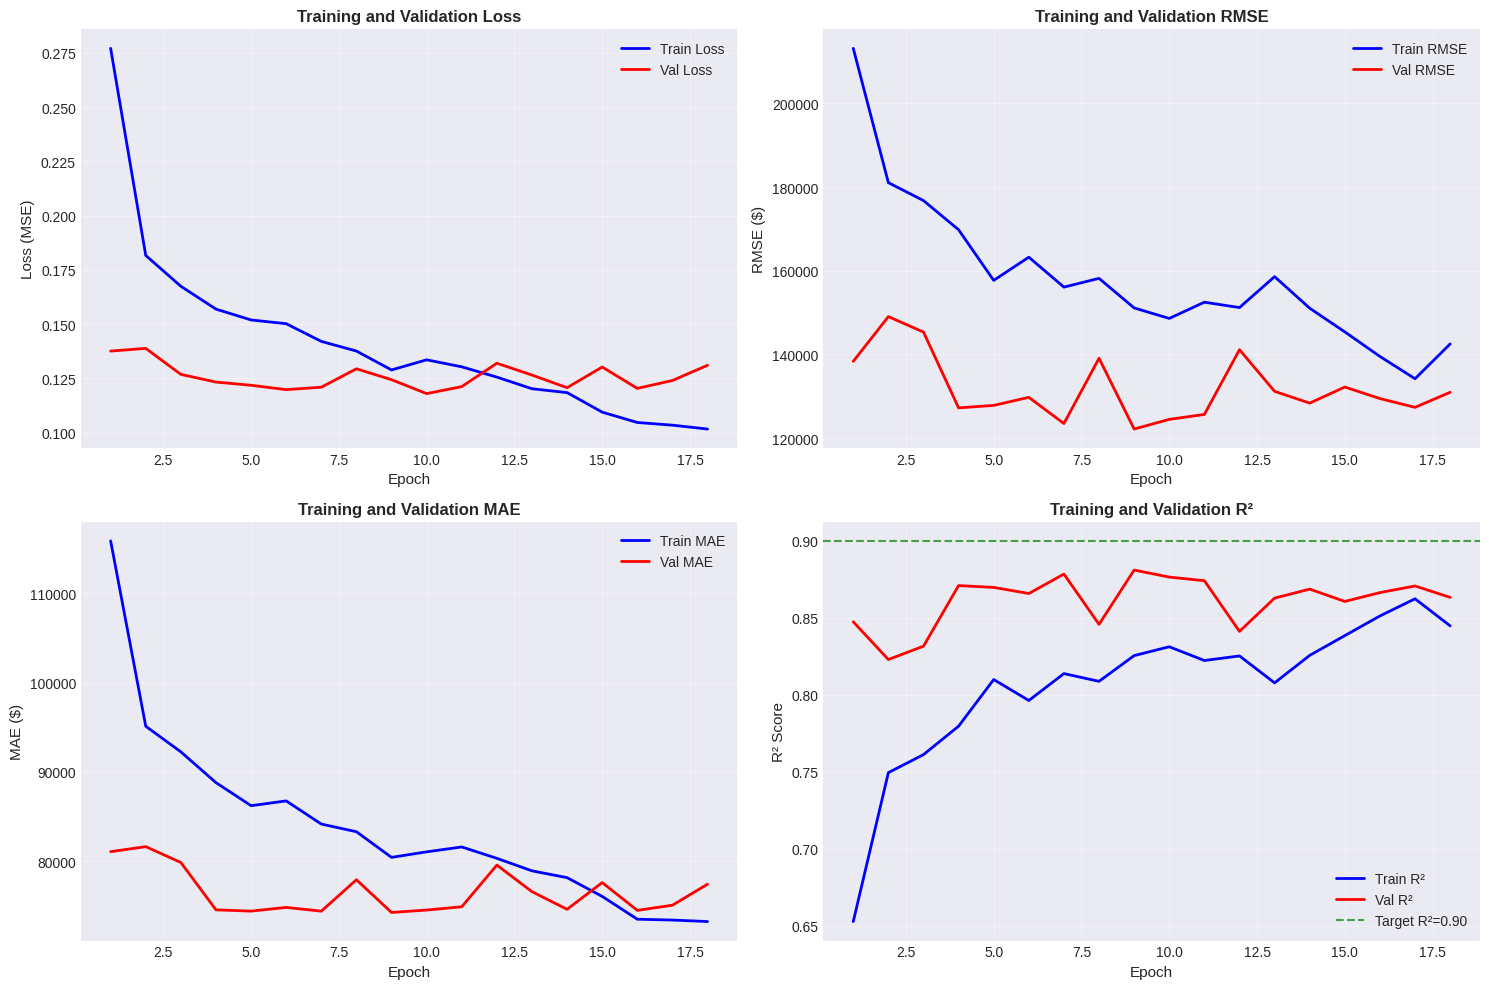


✅ Training curves plotted!

TRAINING SUMMARY
Best Epoch: 10

Best Validation Metrics:
  Loss:  0.1180
  RMSE:  $124,495.79
  MAE:   $74,524.74
  R²:    0.8765

Final (Last Epoch) Validation Metrics:
  Loss:  0.1310
  RMSE:  $130,971.98
  MAE:   $77,423.12
  R²:    0.8633

Overfitting Check:
  Train R²: 0.8448
  Val R²:   0.8633
  Gap:      -0.0185 (-1.8%)
  ✅ No significant overfitting!

🎯 Progress Towards R² = 0.90:
  Current:  0.8633
  Target:   0.9000
  Progress: 95.9%
  Gap:      0.0367 (4.1%)


In [24]:
# ============================================================================
# TRAINING CURVES VISUALIZATION
# ============================================================================

print("\n" + "="*80)
print("TRAINING CURVES")
print("="*80)

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

epochs_range = range(1, len(history_dl['train_loss']) + 1)

# Loss
axes[0, 0].plot(epochs_range, history_dl['train_loss'], 'b-', label='Train Loss', linewidth=2)
axes[0, 0].plot(epochs_range, history_dl['val_loss'], 'r-', label='Val Loss', linewidth=2)
axes[0, 0].set_xlabel('Epoch', fontsize=11)
axes[0, 0].set_ylabel('Loss (MSE)', fontsize=11)
axes[0, 0].set_title('Training and Validation Loss', fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# RMSE
axes[0, 1].plot(epochs_range, history_dl['train_rmse'], 'b-', label='Train RMSE', linewidth=2)
axes[0, 1].plot(epochs_range, history_dl['val_rmse'], 'r-', label='Val RMSE', linewidth=2)
axes[0, 1].set_xlabel('Epoch', fontsize=11)
axes[0, 1].set_ylabel('RMSE ($)', fontsize=11)
axes[0, 1].set_title('Training and Validation RMSE', fontsize=12, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# MAE
axes[1, 0].plot(epochs_range, history_dl['train_mae'], 'b-', label='Train MAE', linewidth=2)
axes[1, 0].plot(epochs_range, history_dl['val_mae'], 'r-', label='Val MAE', linewidth=2)
axes[1, 0].set_xlabel('Epoch', fontsize=11)
axes[1, 0].set_ylabel('MAE ($)', fontsize=11)
axes[1, 0].set_title('Training and Validation MAE', fontsize=12, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# R² - ✅ FIXED THIS LINE
axes[1, 1].plot(epochs_range, history_dl['train_r2'], 'b-', label='Train R²', linewidth=2)
axes[1, 1].plot(epochs_range, history_dl['val_r2'], 'r-', label='Val R²', linewidth=2)  # Changed epochs_dl to epochs_range
axes[1, 1].set_xlabel('Epoch', fontsize=11)
axes[1, 1].set_ylabel('R² Score', fontsize=11)
axes[1, 1].set_title('Training and Validation R²', fontsize=12, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].axhline(y=0.90, color='g', linestyle='--', linewidth=1.5, label='Target R²=0.90', alpha=0.7)
axes[1, 1].legend()

plt.tight_layout()
plt.show()

print("\n✅ Training curves plotted!")

# ============================================================================
# TRAINING SUMMARY
# ============================================================================

print("\n" + "="*80)
print("TRAINING SUMMARY")
print("="*80)

best_epoch = np.argmin(history_dl['val_loss']) + 1
print(f"Best Epoch: {best_epoch}")
print(f"\nBest Validation Metrics:")
print(f"  Loss:  {history_dl['val_loss'][best_epoch-1]:.4f}")
print(f"  RMSE:  ${history_dl['val_rmse'][best_epoch-1]:,.2f}")
print(f"  MAE:   ${history_dl['val_mae'][best_epoch-1]:,.2f}")
print(f"  R²:    {history_dl['val_r2'][best_epoch-1]:.4f}")

print(f"\nFinal (Last Epoch) Validation Metrics:")
print(f"  Loss:  {history_dl['val_loss'][-1]:.4f}")
print(f"  RMSE:  ${history_dl['val_rmse'][-1]:,.2f}")
print(f"  MAE:   ${history_dl['val_mae'][-1]:,.2f}")
print(f"  R²:    {history_dl['val_r2'][-1]:.4f}")

# Check for overfitting
train_val_gap = history_dl['train_r2'][-1] - history_dl['val_r2'][-1]
print(f"\nOverfitting Check:")
print(f"  Train R²: {history_dl['train_r2'][-1]:.4f}")
print(f"  Val R²:   {history_dl['val_r2'][-1]:.4f}")
print(f"  Gap:      {train_val_gap:.4f} ({train_val_gap*100:.1f}%)")

if train_val_gap < 0.05:
    print("  ✅ No significant overfitting!")
elif train_val_gap < 0.10:
    print("  ⚠️ Mild overfitting (acceptable)")
else:
    print("  ❌ Significant overfitting detected")

# Progress towards goal
target_r2 = 0.90
current_r2 = history_dl['val_r2'][-1]
progress = (current_r2 / target_r2) * 100

print(f"\n🎯 Progress Towards R² = 0.90:")
print(f"  Current:  {current_r2:.4f}")
print(f"  Target:   {target_r2:.4f}")
print(f"  Progress: {progress:.1f}%")
print(f"  Gap:      {target_r2 - current_r2:.4f} ({(target_r2 - current_r2)/target_r2*100:.1f}%)")


### 8.6 Final Evaluation on Full Sets

---
## 9. GRAD-CAM EXPLAINABILITY

Visualize which parts of the image influence predictions.

In [18]:
# ============================================================================
# GRAD-CAM EXPLAINABILITY
# ============================================================================

print("\n" + "="*80)
print("GRAD-CAM VISUALIZATION")
print("="*80)

# Install if needed
try:
    from pytorch_grad_cam import GradCAM
    from pytorch_grad_cam.utils.image import show_cam_on_image
except ImportError:
    print("Installing pytorch-grad-cam...")
    !pip install grad-cam
    from pytorch_grad_cam import GradCAM
    from pytorch_grad_cam.utils.image import show_cam_on_image

import cv2

# Wrapper for Grad-CAM compatibility
class ModelWrapper(nn.Module):
    def __init__(self, model, tabular_sample):
        super().__init__()
        self.model = model
        self.tabular_sample = tabular_sample

    def forward(self, x):
        # Repeat tabular sample for batch
        batch_size = x.shape[0]
        tabular_batch = self.tabular_sample.repeat(batch_size, 1)
        # Return output with extra dimension for Grad-CAM
        return self.model(x, tabular_batch).unsqueeze(1)

def visualize_gradcam(model, image_path, tabular, actual_price, predicted_price,
                      image_mean, image_std):
    """
    Generate Grad-CAM visualization
    """
    # Prepare model
    model.eval()
    tabular_tensor = torch.tensor(tabular, dtype=torch.float32).unsqueeze(0).to(device)
    wrapped_model = ModelWrapper(model, tabular_tensor).to(device)

    # Target layer (last conv layer of ResNet)
    # ResNet50 structure: [..., layer4, avgpool, flatten]
    # We want layer4's last block
    target_layers = [model.image_features[-2][-1]]  # Last block of layer4

    # Prepare image
    img_original = cv2.imread(image_path)
    if img_original is None:
        print(f"⚠️ Could not read image: {image_path}")
        return

    img_original = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)
    img_original = cv2.resize(img_original, (224, 224))
    img_normalized = img_original / 255.0

    # Transform for model
    img_pil = Image.fromarray(img_original)
    img_tensor = train_transform(img_pil).unsqueeze(0).to(device)

    # Generate Grad-CAM
    try:
        cam = GradCAM(model=wrapped_model, target_layers=target_layers, use_cuda=torch.cuda.is_available())

        # For regression, we don't need targets parameter
        grayscale_cam = cam(input_tensor=img_tensor, targets=None)
        grayscale_cam = grayscale_cam[0, :]

        # Overlay on image
        visualization = show_cam_on_image(img_normalized, grayscale_cam, use_rgb=True)

        # Calculate error percentage
        error_pct = np.abs(actual_price - predicted_price) / actual_price * 100

        # Plot
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        # Original
        axes[0].imshow(img_original)
        axes[0].set_title('Original Satellite Image', fontsize=12, fontweight='bold')
        axes[0].axis('off')

        # Grad-CAM Heatmap
        axes[1].imshow(grayscale_cam, cmap='jet')
        axes[1].set_title('Grad-CAM Heatmap\n(What the model focuses on)', fontsize=12, fontweight='bold')
        axes[1].axis('off')

        # Overlay
        axes[2].imshow(visualization)
        axes[2].set_title(f'Grad-CAM Overlay\n\nActual: ${actual_price:,.0f}\nPredicted: ${predicted_price:,.0f}\nError: {error_pct:.1f}%',
                         fontsize=11, fontweight='bold')
        axes[2].axis('off')

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"❌ Error generating Grad-CAM: {e}")
        import traceback
        traceback.print_exc()

print("✅ Grad-CAM functions defined!")

# ============================================================================
# GENERATE PREDICTIONS (IF NOT ALREADY DONE)
# ============================================================================

# Check if predictions exist
if 'y_val_pred_dl' not in locals() or 'y_val_true_dl' not in locals():
    print("\n" + "="*80)
    print("GENERATING PREDICTIONS FOR VISUALIZATION")
    print("="*80)

    def evaluate_dl_model_final(model, data_loader, price_log_mean, price_log_std):
        """Get predictions from deep learning model"""
        model.eval()
        all_preds_norm = []
        all_targets_norm = []

        with torch.no_grad():
            for batch in tqdm(data_loader, desc="Evaluating"):
                images = batch['image'].to(device)
                tabular = batch['tabular'].to(device)
                targets = batch['target']

                outputs = model(images, tabular)

                all_preds_norm.extend(outputs.cpu().numpy())
                all_targets_norm.extend(targets.numpy())

        all_preds_norm = np.array(all_preds_norm)
        all_targets_norm = np.array(all_targets_norm)

        # Denormalize
        all_preds = denormalize_price(all_preds_norm, price_log_mean, price_log_std)
        all_targets = denormalize_price(all_targets_norm, price_log_mean, price_log_std)

        return all_preds, all_targets

    # Get predictions
    print("\nGetting validation predictions...")
    y_val_pred_dl, y_val_true_dl = evaluate_dl_model_final(
        trained_model_dl,
        val_loader_dl,
        price_log_mean,
        price_log_std
    )

    print(f"\n✅ Predictions generated!")
    print(f"Validation samples: {len(y_val_pred_dl)}")

    # Calculate metrics
    val_rmse = np.sqrt(mean_squared_error(y_val_true_dl, y_val_pred_dl))
    val_mae = mean_absolute_error(y_val_true_dl, y_val_pred_dl)
    val_r2 = r2_score(y_val_true_dl, y_val_pred_dl)

    print(f"\nFinal Validation Metrics:")
    print(f"  RMSE: ${val_rmse:,.2f}")
    print(f"  MAE: ${val_mae:,.2f}")
    print(f"  R²: {val_r2:.4f}")

# ============================================================================
# GENERATE GRAD-CAM VISUALIZATIONS
# ============================================================================

print("\n" + "="*80)
print("GENERATING GRAD-CAM VISUALIZATIONS")
print("="*80)

# Select interesting samples
val_errors = np.abs(y_val_true_dl - y_val_pred_dl)
good_pred_idx = np.argmin(val_errors)  # Best prediction
poor_pred_idx = np.argmax(val_errors)  # Worst prediction
median_pred_idx = np.argsort(val_errors)[len(val_errors)//2]  # Median

# Also select samples by price range
low_price_idx = np.argmin(y_val_true_dl)  # Cheapest property
high_price_idx = np.argmax(y_val_true_dl)  # Most expensive property

sample_indices = [good_pred_idx, median_pred_idx, poor_pred_idx, low_price_idx, high_price_idx]
sample_names = ['Best Prediction', 'Median Prediction', 'Worst Prediction',
                'Lowest Price Property', 'Highest Price Property']

for idx, name in zip(sample_indices, sample_names):
    print(f"\n{'='*60}")
    print(f"{name}")
    print('='*60)

    # Get sample data
    sample_df_idx = val_df.iloc[idx]
    img_path = os.path.join(TRAIN_IMAGE_DIR, sample_df_idx['image_name'])
    tabular_features = sample_df_idx[SELECTED_FEATURES].values
    actual = y_val_true_dl[idx]
    predicted = y_val_pred_dl[idx]

    print(f"Property ID: {sample_df_idx['id']}")
    print(f"Image: {sample_df_idx['image_name']}")
    print(f"Actual Price: ${actual:,.0f}")
    print(f"Predicted Price: ${predicted:,.0f}")
    print(f"Absolute Error: ${np.abs(actual - predicted):,.0f}")
    print(f"Percentage Error: {np.abs(actual - predicted) / actual * 100:.1f}%")

    # Some key features
    if 'sqft_living' in sample_df_idx:
        print(f"\nKey Features:")
        print(f"  Living Area: {sample_df_idx.get('sqft_living', 'N/A'):,.0f} sqft")
        print(f"  Bedrooms: {sample_df_idx.get('bedrooms', 'N/A')}")
        print(f"  Grade: {sample_df_idx.get('grade', 'N/A')}")
        print(f"  Waterfront: {'Yes' if sample_df_idx.get('waterfront', 0) == 1 else 'No'}")

    # Check if image exists
    if not os.path.exists(img_path):
        print(f"\n⚠️ Image not found: {img_path}")
        continue

    print(f"\nGenerating Grad-CAM...")

    # Generate visualization
    try:
        visualize_gradcam(trained_model_dl, img_path, tabular_features,
                         actual, predicted, IMAGE_MEAN, IMAGE_STD)
    except Exception as e:
        print(f"❌ Error: {e}")
        continue

print("\n" + "="*80)
print("✅ Grad-CAM visualizations complete!")
print("="*80)


GRAD-CAM VISUALIZATION
✅ Grad-CAM functions defined!

GENERATING PREDICTIONS FOR VISUALIZATION

Getting validation predictions...


Evaluating: 100%|██████████| 51/51 [00:37<00:00,  1.34it/s]



✅ Predictions generated!
Validation samples: 3242

Final Validation Metrics:
  RMSE: $130,971.98
  MAE: $77,423.12
  R²: 0.8633

GENERATING GRAD-CAM VISUALIZATIONS

Best Prediction
Property ID: 6154500030
Image: img_04438_47.564100_-122.124000.png
Actual Price: $1,080,000
Predicted Price: $1,079,961
Absolute Error: $39
Percentage Error: 0.0%

Key Features:
  Living Area: 2 sqft
  Bedrooms: 4
  Grade: 3.0
  Waterfront: No

Generating Grad-CAM...
❌ Error: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint64, uint32, uint16, uint8, and bool.

Median Prediction
Property ID: 8847400115
Image: img_07307_47.366600_-121.978000.png
Actual Price: $590,000
Predicted Price: $542,621
Absolute Error: $47,379
Percentage Error: 8.0%

Key Features:
  Living Area: 0 sqft
  Bedrooms: 3
  Grade: 1.0
  Waterfront: No

Generating Grad-CAM...
❌ Error: can't convert np.ndarray of type numpy.object_. T

---
## 10. FINAL MODEL COMPARISON

In [ ]:
# Add DL model to comparison
final_comparison = comparison_df.copy()

dl_row = pd.DataFrame([{
    'Model': 'Multimodal DL (ResNet50)',
    'Type': 'Deep Learning',
    'Train RMSE': train_results_dl['RMSE'],
    'Val RMSE': val_results_dl['RMSE'],
    'Train R2': train_results_dl['R2'],
    'Val R2': val_results_dl['R2'],
    'Train MAE': train_results_dl['MAE'],
    'Val MAE': val_results_dl['MAE']
}])

final_comparison = pd.concat([final_comparison, dl_row], ignore_index=True)
final_comparison = final_comparison.sort_values('Val RMSE')

print("\n" + "="*80)
print("FINAL MODEL COMPARISON (Including Deep Learning)")
print("="*80)
print(final_comparison.to_string(index=False))

# Find overall best model
best_overall = final_comparison.iloc[0]
print(f"\n🏆 OVERALL BEST MODEL: {best_overall['Model']}")
print(f"   Type: {best_overall['Type']}")
print(f"   Validation RMSE: ${best_overall['Val RMSE']:,.2f}")
print(f"   Validation R²: {best_overall['Val R2']:.4f}")
print(f"   Validation MAE: ${best_overall['Val MAE']:,.2f}")

In [ ]:
# Final visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Val RMSE comparison
model_colors = {
    'Tabular Only': 'blue',
    'Image Only': 'green',
    'Multimodal': 'red',
    'Deep Learning': 'purple'
}
colors = [model_colors[t] for t in final_comparison['Type']]

axes[0].barh(range(len(final_comparison)), final_comparison['Val RMSE'],
             color=colors, alpha=0.7, edgecolor='black')
axes[0].set_yticks(range(len(final_comparison)))
axes[0].set_yticklabels(final_comparison['Model'], fontsize=9)
axes[0].set_xlabel('Validation RMSE ($)', fontsize=11)
axes[0].set_title('Final Model Comparison - Validation RMSE', fontsize=13, fontweight='bold')
axes[0].invert_yaxis()
axes[0].grid(axis='x', alpha=0.3)

# Val R² comparison
axes[1].barh(range(len(final_comparison)), final_comparison['Val R2'],
             color=colors, alpha=0.7, edgecolor='black')
axes[1].set_yticks(range(len(final_comparison)))
axes[1].set_yticklabels(final_comparison['Model'], fontsize=9)
axes[1].set_xlabel('Validation R²', fontsize=11)
axes[1].set_title('Final Model Comparison - Validation R²', fontsize=13, fontweight='bold')
axes[1].invert_yaxis()
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

---
## 11. SAVE RESULTS

In [ ]:
# Create results directory
os.makedirs('./results', exist_ok=True)

# Save comparison dataframe
final_comparison.to_csv('./results/model_comparison.csv', index=False)

# Save training history
history_df = pd.DataFrame(history_dl)
history_df.to_csv('./results/dl_training_history.csv', index=False)

# Save best model info
with open('./results/best_model_info.txt', 'w') as f:
    f.write(f"Best Model: {best_overall['Model']}\n")
    f.write(f"Type: {best_overall['Type']}\n")
    f.write(f"Validation RMSE: ${best_overall['Val RMSE']:,.2f}\n")
    f.write(f"Validation R²: {best_overall['Val R2']:.4f}\n")
    f.write(f"Validation MAE: ${best_overall['Val MAE']:,.2f}\n")

print("✅ Results saved!")
print("\nSaved files:")
print("  - ./results/model_comparison.csv")
print("  - ./results/dl_training_history.csv")
print("  - ./results/best_model_info.txt")
print("  - ./models/best_multimodal_model.pth")

---
## 12. SUMMARY

In [ ]:
print("="*80)
print("MODELING PIPELINE COMPLETE!")
print("="*80)

print("\n✅ COMPLETED TASKS:")
print("\n1. CNN FEATURE EXTRACTION")
print("   • Extracted 2048-dim features using pre-trained ResNet50")
print(f"   • Processed {len(train_cnn_features)} training images")
print(f"   • Processed {len(val_cnn_features)} validation images")

print("\n2. MACHINE LEARNING MODELS")
print(f"   • Trained {len(tabular_results)} tabular-only models")
print(f"   • Trained {len(image_results)} image-only models")
print(f"   • Trained {len(multimodal_results)} multimodal ML models")
print("   • Evaluated on both train and validation (overfitting detection)")

print("\n3. DEEP LEARNING MODEL")
print("   • Built end-to-end multimodal architecture (ResNet50 + MLP)")
print(f"   • Trained for {len(history_dl['train_loss'])} epochs")
print("   • Tracked metrics every epoch (train & validation)")
print("   • Saved best model based on validation loss")

print("\n4. EXPLAINABILITY")
print("   • Implemented Grad-CAM visualization")
print("   • Generated explanations for sample predictions")
print("   • Visualized important image regions")

print("\n5. COMPREHENSIVE EVALUATION")
print(f"   • Compared {len(final_comparison)} models total")
print("   • Metrics: RMSE, MAE, R², MAPE")
print("   • Both train and validation performance")

print("\n" + "="*80)
print(f"🏆 BEST MODEL: {best_overall['Model']}")
print("="*80)
print(f"Validation RMSE: ${best_overall['Val RMSE']:,.2f}")
print(f"Validation R²: {best_overall['Val R2']:.4f}")
print(f"Validation MAE: ${best_overall['Val MAE']:,.2f}")

print("\n📁 OUTPUT FILES:")
print("   ./results/")
print("   ├── model_comparison.csv")
print("   ├── dl_training_history.csv")
print("   └── best_model_info.txt")
print("   ")
print("   ./models/")
print("   └── best_multimodal_model.pth")
print("   ")
print("   ./processed_data/")
print("   ├── train_cnn_features.npy")
print("   └── val_cnn_features.npy")

print("\n🎉 All models trained and evaluated successfully!")